# AutoInland Vehicle Insurance Claim Challenge EDA Notebook - Python

This notebook covers Data Preparation for AutoInland Insurance Modelling:
- Loading the data
- EDA and feature enginnering
- Data preprocessing and data wrangling
- Final Data Preparation

## Importing libraries

In [781]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random


import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')

random.seed(48)
np.random.seed(48)


## Read files

In [782]:
# Load files into a pandas dataframe
train = pd.read_csv('./Train.csv')
test = pd.read_csv('./Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
var_def = pd.read_csv('VariableDefinitions.csv')

In [783]:
states = pd.read_csv('./NigerianStateNames.csv')

## EDA

In [784]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [785]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [786]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [787]:
#Variable definitions
var_def

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [788]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


In [789]:
#Quick summary of target distribution

train['target'].value_counts()

0    10624
1     1455
Name: target, dtype: int64

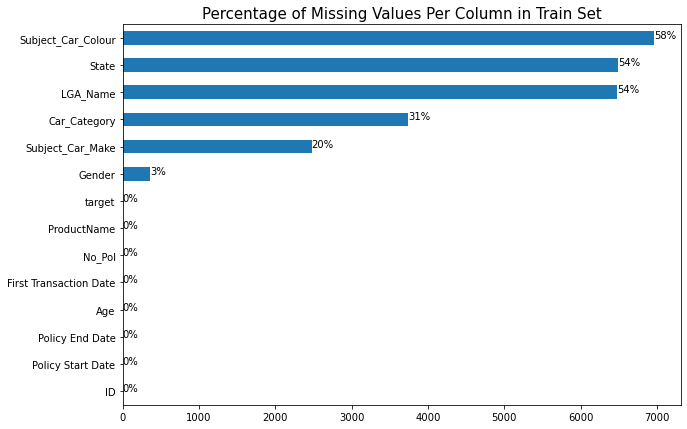

In [790]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

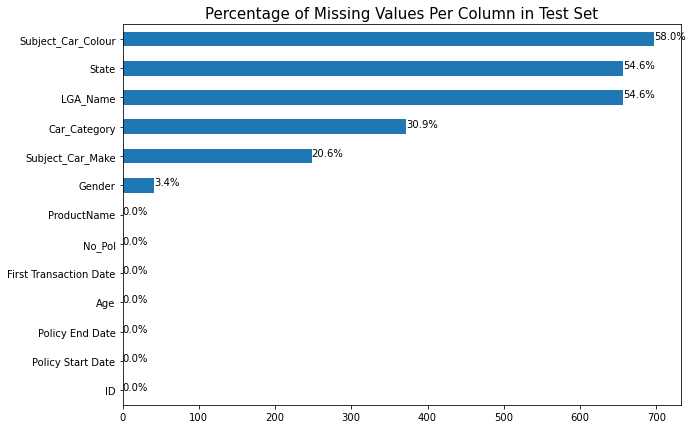

In [791]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Similar distribution of null values btw train and test

*Do the same users repeat in the train set?*

In [792]:
train['ID'].value_counts().max()

1

*Do the same users repeat in the train and test set?*

In [793]:
set(train['ID'].unique()).intersection(set(test['ID'].unique()))

set()

## Combine train and test set for easy preprocessing 

In [794]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

train['tag'] = 'train'

test['tag'] = 'test'

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 15)


In [795]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,tag
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN,test
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN,test
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN,test
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN,test
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN,test


In [796]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
 14  tag                     13281 non-null

In [797]:
# Change each column to its appriopriate datatype

date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target', 'tag']]


for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype(str)

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  13281 non-null  object        
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            13281 non-null  object        
 8   Subject_Car_Colour      13281 non-null  object        
 9   Subject_Car_Make        13281 non-null  object        
 10  LGA_Name                13281 non-null  object        
 11  State                   13281 non-null  object        
 12  ProductName             13281 non-null  object

**Train vs Test Distribution**

In [798]:
#Train not in Test

for col in cat_cols:
    
    print(f"Distribution for Category {col}")

    print(set(train[col].unique())-(set(test[col].unique())))
    
    print("==========" * 10)

Distribution for Category Gender
set()
Distribution for Category Car_Category
{'CAMRY CAR HIRE', 'Van', 'Tipper Truck', 'Shape Of Vehicle Chasis', 'Wagon', 'Mini Van'}
Distribution for Category Subject_Car_Colour
{'Yellow & White', 'White & Blue', 'White & Red', 'White & Yellow', 'D. Red', 'Blue & Red', 'Black & Orange', 'Beige Mitalic', 'Champagne', 'Red & Blue', 'Blue&White&Red', 'D. Gold', 'Dark Blue', 'Black & White', 'Burgundy', 'Orange', 'Gray & Gray', 'Light Green', 'Red & White', 'Blue Sky', 'Light Blue', 'Red & Yellow', 'Light Gray', 'Dark Green', 'Dark Red', 'Gray & Silver', 'Yellow', 'Red & Black', 'Purple'}
Distribution for Category Subject_Car_Make
{'MG', 'Geely', 'Fiat', 'REXTON', 'Motorcycle', 'Innson', 'Seat', 'BRILLIANCE', 'Jeep', 'Jaguar', 'Ashok Leyland', 'Astra', 'Howo', 'Man', 'ZOYTE', 'Raston', 'Land Rover.', 'Caddillac', 'Lincoln', 'FOTON', 'Bajaj', 'GAC', 'Grand Cherokee', 'Isuzu', 'Jincheng', 'Yamaha', 'ABG', 'Black', 'COMMANDER', 'Buik', 'Rols Royce', 'Hummer'

In [799]:
#Test not in Train

for col in cat_cols:
    
    print(f"Distribution for Category {col}")

    print(set(test[col].unique())-(set(train[col].unique())))
    
    print("==========" * 10)

Distribution for Category Gender
set()
Distribution for Category Car_Category
set()
Distribution for Category Subject_Car_Colour
{'Red Maroon'}
Distribution for Category Subject_Car_Make
{'Datsun'}
Distribution for Category LGA_Name
{'Ekwusigo', 'Ifako-Agege', 'Benue', 'Hong', 'VGC', 'AGBARA', 'Ngor-Okpala', 'Okpokwu', 'Ankpa', 'AKOWONJO', 'Idemili south', 'Zaria'}
Distribution for Category State
{'Ngor-Okpala', 'Idemili-south'}
Distribution for Category ProductName
set()


In [800]:
all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,tag
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,nan,nan,Car Classic,0.0,train
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,nan,nan,Car Classic,1.0,train
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,nan,nan,Car Classic,0.0,train
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,nan,nan,nan,nan,nan,CarSafe,0.0,train
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,nan,nan,nan,Lagos,Lagos,Muuve,1.0,train


### Univariate Feature Understanding & Data Preparation

### Numeric-

**AGE**

In [801]:
all_data.describe()

,Age,No_Pol,target
count,13281.000000,13281.000000,12079.000000
mean,42.375574,1.302763,0.120457
std,93.170951,0.723195,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


Observation- Negative age, potential outlier or maybe missing value

In [802]:
all_data[all_data['Age'] < 0]

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,tag
909,ID_2SKRJKI,2010-04-30,2011-04-29,Female,-76,2010-04-30,2,nan,White,Hyundai,Ilupeju,Lagos,CVTP,0.0,train
1226,ID_3QOZW9J,2010-03-15,2011-03-14,Male,-2,2010-03-15,1,Saloon,Black,TOYOTA,Ibadan South East,Ibadan-East,Customized Motor,0.0,train
2580,ID_7OMERTL,2010-04-23,2011-04-22,Male,-12,2010-04-23,3,Saloon,As Attached,Hyundai,Victoria Island,Lagos,Car Plus,0.0,train
3114,ID_98EVCPR,2010-06-26,2011-06-25,Female,-2,2010-06-26,1,JEEP,nan,TOYOTA,nan,nan,Car Classic,0.0,train
3427,ID_A3YN75Z,2010-10-02,2011-10-01,NOT STATED,-6099,2010-10-02,1,nan,nan,nan,nan,nan,CarSafe,0.0,train
3518,ID_AE3U4I4,2010-01-16,2011-01-15,Female,-5939,2010-01-16,2,nan,As Attached,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,train
3649,ID_AUPXOA1,2010-08-04,2011-08-03,Male,-22,2010-08-04,1,Saloon,nan,Mercedes,Oshodi-Isolo,Oshodi-Isolo,CarSafe,0.0,train
5173,ID_FKJFVMX,2010-12-14,2011-01-13,Female,-5939,2010-12-14,2,nan,nan,nan,Victoria Island,Lagos,Customized Motor,1.0,train
6387,ID_J0OJ082,2010-04-23,2011-04-22,Male,-12,2010-04-23,3,Saloon,nan,Hyundai,Victoria Island,Lagos,Car Plus,0.0,train
6856,ID_KK04G4Y,2010-04-30,2011-04-29,Female,-76,2010-04-30,2,nan,nan,Hyundai,Ilupeju,Lagos,CVTP,0.0,train


Negative age instances both in train and test set. Does replacing the negative plausible age with absolute age help while treating large -ves as null. Or we replace all -ve as null. Decision to be made based on cross val score. 

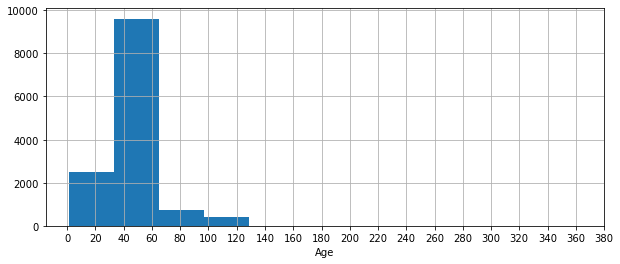

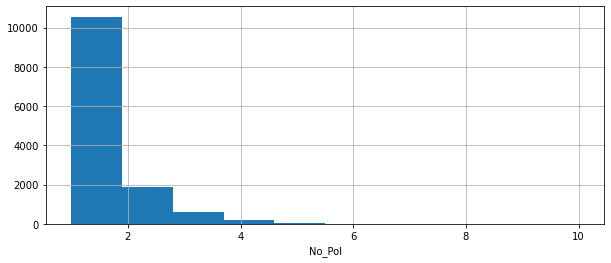

In [803]:
#Numerical histogram of features

for num in num_cols:
    
    all_data[all_data[num]>0][num].hist(figsize=(10, 4))
    
    plt.xlabel(num)
    
    if num == 'Age':
    
        plt.xticks(range(0, 400, 20))
    
    plt.show()

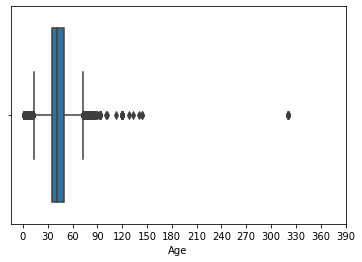

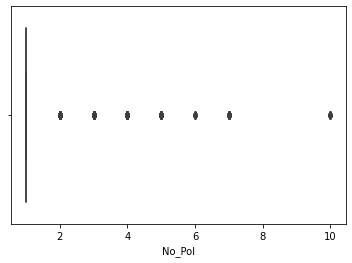

In [804]:
for num in num_cols:
    
    sns.boxplot(all_data[all_data[num]>0][num])
    
    if num == 'Age':
    
        plt.xticks(range(0, 400, 30))
    
    plt.show()

Observation- 

Age: Low age instances in data set. The most plausible age for autoinsurance according to domain knowledge is around 18. Investigate ages less than 18.  Minors can have co-insurance policies with parents

Maximum possible age a person lives in the world is around 150. Treat values greater than 150 differently. Possible outliers with ages between 280-320. Investigate high age ranges.

Consider creating age group to capture age grouping insights (Feature Engineering). Confirm domain knowledge with target EDA.

No_Pol: Higher frequency no of policies of 1. What kind of users use more than 1 policy? Is there a pattern between the no of polices a user takes compared to years on platform?



Age: Null age of values in 1000s only present in train set. Potential outlier.
Age equals to 320 in both train and test set. 
Minimum realistic age for driving & autoinsurance is 18, can we just treat all less than 17 as minors to represent the minor grouping.


We do the feature engineering for numeric features after data exploration to understand how to handle erroneous, unlikely or null data.

### Date Features-

In [805]:
all_data[all_data['Policy Start Date'] == all_data['First Transaction Date']]

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,tag
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,nan,nan,Car Classic,0.0,train
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,nan,nan,Car Classic,1.0,train
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,nan,nan,Car Classic,0.0,train
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,nan,nan,nan,nan,nan,CarSafe,0.0,train
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,nan,nan,nan,Lagos,Lagos,Muuve,1.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN,test
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN,test
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN,test
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,nan,Nissan,Aba North,Aba-North,Car Classic,NaN,test


Policy Start date is exactly First Transaction Date

In [806]:
# Extract date features from the date columns
for col in ['Policy Start Date', 'Policy End Date']:
  for date_feature in ['year', 'month', 'day', 'dayofweek']:
    all_data[col+" " + date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,tag,Policy Start Date year,Policy Start Date month,Policy Start Date day,Policy Start Date dayofweek,Policy End Date year,Policy End Date month,Policy End Date day,Policy End Date dayofweek
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0.0,train,2010,5,14,4,2011,5,13,4
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1.0,train,2010,11,29,0,2011,11,28,0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,0.0,train,2010,3,21,6,2011,3,20,6
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,nan,nan,nan,...,0.0,train,2010,8,21,5,2011,8,20,5
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,nan,nan,nan,...,1.0,train,2010,8,29,6,2010,12,31,4


In [807]:
all_data.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target', 'tag', 'Policy Start Date year',
       'Policy Start Date month', 'Policy Start Date day',
       'Policy Start Date dayofweek', 'Policy End Date year',
       'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek'],
      dtype='object')

In [808]:
all_data['weekinmonth'] = all_data['Policy Start Date day']//7

all_data['weekinmonth'] = all_data['weekinmonth'].replace(4, 3)

all_data['weekinmonth'] = all_data['weekinmonth'] + 1

In [809]:
all_data['Policy Start Date year'].value_counts()

2010    13267
2009        6
2006        2
2003        2
2007        1
2005        1
2002        1
2001        1
Name: Policy Start Date year, dtype: int64

In [810]:
all_data['Policy End Date year'].value_counts()

2011    13096
2010      177
2012        2
2041        2
2016        2
2037        1
2034        1
Name: Policy End Date year, dtype: int64

Investigate low policy start years and high policy end years

In [811]:
all_data[all_data['Policy Start Date year'] < 2009]

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,tag,Policy Start Date year,Policy Start Date month,Policy Start Date day,Policy Start Date dayofweek,Policy End Date year,Policy End Date month,Policy End Date day,Policy End Date dayofweek,weekinmonth
912,ID_2SWIGKH,2007-03-04,2037-08-03,Male,37,2007-03-04,1,Saloon,Gold,TOYOTA,...,train,2007,3,4,6,2037,8,3,0,1
4442,ID_DC8ITK4,2006-07-06,2016-09-06,Male,39,2006-07-06,3,Saloon,nan,TOYOTA,...,train,2006,7,6,3,2016,9,6,1,1
8010,ID_O51ZQ1B,2001-12-11,2011-12-10,Female,37,2001-12-11,1,Saloon,Black,Honda,...,train,2001,12,11,1,2011,12,10,5,2
8124,ID_OEWBKGF,2005-08-05,2011-09-29,Female,44,2005-08-05,1,nan,nan,Tata,...,train,2005,8,5,4,2011,9,29,3,1
10234,ID_ULWS8VL,2003-04-13,2011-04-12,Male,41,2003-04-13,2,Saloon,Black,TOYOTA,...,train,2003,4,13,6,2011,4,12,1,2
10526,ID_VJ1FAVO,2002-03-25,2011-03-24,Male,37,2002-03-25,1,Saloon,Black,TOYOTA,...,train,2002,3,25,0,2011,3,24,3,4
10708,ID_W0VIHSI,2006-03-24,2011-04-28,Male,45,2006-03-24,1,nan,nan,Mack,...,train,2006,3,24,4,2011,4,28,3,4
12066,ID_ZYKGSP7,2003-12-21,2034-05-20,Male,48,2003-12-21,2,Saloon,nan,BMW,...,train,2003,12,21,6,2034,5,20,5,4


In [812]:
all_data[all_data['Policy End Date year'] > 2012]

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,tag,Policy Start Date year,Policy Start Date month,Policy Start Date day,Policy Start Date dayofweek,Policy End Date year,Policy End Date month,Policy End Date day,Policy End Date dayofweek,weekinmonth
685,ID_2484F7U,2010-10-19,2041-04-18,Male,36,2010-10-19,1,Saloon,nan,TOYOTA,...,train,2010,10,19,1,2041,4,18,3,3
912,ID_2SWIGKH,2007-03-04,2037-08-03,Male,37,2007-03-04,1,Saloon,Gold,TOYOTA,...,train,2007,3,4,6,2037,8,3,0,1
2076,ID_6BJMPUY,2009-02-26,2016-06-25,Male,37,2009-02-26,1,Saloon,Black,TOYOTA,...,train,2009,2,26,3,2016,6,25,5,4
4442,ID_DC8ITK4,2006-07-06,2016-09-06,Male,39,2006-07-06,3,Saloon,nan,TOYOTA,...,train,2006,7,6,3,2016,9,6,1,1
11341,ID_XUX9C48,2010-10-19,2041-04-18,Male,36,2010-10-19,1,Saloon,nan,TOYOTA,...,train,2010,10,19,1,2041,4,18,3,3
12066,ID_ZYKGSP7,2003-12-21,2034-05-20,Male,48,2003-12-21,2,Saloon,nan,BMW,...,train,2003,12,21,6,2034,5,20,5,4


Distribution only present in train set

In [813]:
#Replacing with missing

all_data.loc[all_data['Policy End Date year'] > 2012, 'Policy End Date year'] = np.nan


all_data.loc[all_data['Policy Start Date year'] < 2009, 'Policy Start Date year'] = np.nan

***Feature Engineering: Extract Date Features for EDA & understanding***

In [814]:
all_data['Policy_delta'] = all_data['Policy End Date'] - all_data['Policy Start Date']

In [815]:
all_data['Policy_delta'] =  all_data['Policy_delta'].dt.days 

In [816]:
#Replace missing values 

all_data.loc[all_data['Policy Start Date year'].isnull() == True, 'Policy_delta'] = np.nan

all_data.loc[all_data['Policy End Date year'].isnull() == True, 'Policy_delta'] = np.nan

In [817]:
all_data['Policy_delta'].describe()

count    13270.000000
mean       344.620874
std         59.967465
min         12.000000
25%        364.000000
50%        364.000000
75%        364.000000
max        729.000000
Name: Policy_delta, dtype: float64

Average period of autoinsurance is between 6 months-1 years. Max of 2 years.

Why do people have shorter than 6 months period, did they cancel early?

In [818]:
#Normalize to years

all_data['Policy_delta'] =  all_data['Policy_delta'] / 364

In [819]:
all_data['Policy_delta'].describe()

count    13270.000000
mean         0.946761
std          0.164746
min          0.032967
25%          1.000000
50%          1.000000
75%          1.000000
max          2.002747
Name: Policy_delta, dtype: float64

In [820]:
all_data[all_data['Policy_delta'] < 0.5]['target'].value_counts()

0.0    566
1.0    106
Name: target, dtype: int64

In [821]:
#Create 3 months features from Policy Start Date

for col in [1, 2, 3]:
    
    all_data['Date Next ' + str(col) + ' Months'] = all_data['Policy Start Date'] + DateOffset(months = col)
    
    all_data['Next ' + str(col) + ' Months'] = all_data['Date Next ' + str(col) + ' Months'].dt.month
    
    all_data['Next ' + str(col) + ' Quarters'] = all_data['Date Next ' + str(col) + ' Months'].dt.quarter
    
                                  

**Create Season conditions**

In [822]:
spring = [3, 4, 5]

summer = [6, 7, 8]

autumn = [9, 10, 11]

winter = [12, 1, 2]


In [823]:
all_data[['summer', 'winter', 'spring', 'autumn']] = 0

In [824]:
def create_season_condition(df, season):
    
    season_count = 0
    
    
    for dates in ['Policy Start Date month', 'Next 1 Months', 'Next 2 Months', 'Next 3 Months']:
        
        if df[dates] in season:
            
            season_count += 1
            
            
    return season_count

In [825]:
all_data['spring'] = all_data.apply(create_season_condition, args = [spring], axis = 1)

all_data['summer'] = all_data.apply(create_season_condition, args = [summer], axis = 1)

all_data['autumn'] = all_data.apply(create_season_condition, args = [autumn], axis = 1)

all_data['winter'] = all_data.apply(create_season_condition, args = [winter], axis = 1)

In [826]:
date_cols = [col for col in list(all_data.columns) if (('Next' in col) or ('Date' in col)) & \
               (all_data[col].dtype != '<M8[ns]')]

In [827]:
all_data.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target', 'tag', 'Policy Start Date year',
       'Policy Start Date month', 'Policy Start Date day',
       'Policy Start Date dayofweek', 'Policy End Date year',
       'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'weekinmonth', 'Policy_delta',
       'Date Next 1 Months', 'Next 1 Months', 'Next 1 Quarters',
       'Date Next 2 Months', 'Next 2 Months', 'Next 2 Quarters',
       'Date Next 3 Months', 'Next 3 Months', 'Next 3 Quarters', 'summer',
       'winter', 'spring', 'autumn'],
      dtype='object')

Create seasonal features - Festive seasons and rainfall, rainfall seasons varies by state regions. Hence, we include the information after EDA stage completed:

There are 3 major festive seasons in Nigeria:

1) EASTER- March-April

2) XMAS- December-January

3) SUMMER - July-August

In [828]:
def check_is_festive(df):
    
    festive = [3, 4, 7, 8, 12]
    
    festive_count = 0
    
    
    for dates in ['Policy Start Date month', 'Next 1 Months', 'Next 2 Months', 'Next 3 Months']:
        
        if df[dates] in festive:
            
            festive_count += 1
            
            
    return festive_count
    


In [829]:
all_data['Policy_isfestive'] = all_data.apply(check_is_festive, axis = 1)

In [830]:
all_data.groupby('Policy_isfestive')['target'].mean()

Policy_isfestive
1    0.101963
2    0.129353
Name: target, dtype: float64

In [831]:
#Convert to binary

all_data['Policy_isfestive']=  all_data['Policy_isfestive'].replace({2 : 1, 1: 0})

In [832]:
all_data.describe()

,Age,No_Pol,target,Policy Start Date year,Policy Start Date month,Policy Start Date day,Policy Start Date dayofweek,Policy End Date year,Policy End Date month,Policy End Date day,...,Next 1 Quarters,Next 2 Months,Next 2 Quarters,Next 3 Months,Next 3 Quarters,summer,winter,spring,autumn,Policy_isfestive
count,13281.000000,13281.000000,12079.000000,13273.000000,13281.000000,13281.000000,13281.000000,13275.000000,13281.000000,13281.000000,...,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000
mean,42.375574,1.302763,0.120457,2009.999548,6.382275,16.154506,3.445524,2010.986817,5.871169,15.998494,...,2.468188,6.422483,2.458173,6.403283,2.486183,0.964988,1.013252,1.046683,0.975077,0.676229
std,93.170951,0.723195,0.325509,0.021257,3.502905,8.874429,2.120057,0.115374,3.501813,8.963396,...,1.121961,3.450603,1.118607,3.424773,1.116542,1.121354,1.153298,1.163225,1.148950,0.467931
min,-6099.000000,1.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,2010.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,1.000000,0.000000,2010.000000,3.000000,8.000000,2.000000,2011.000000,3.000000,8.000000,...,1.000000,3.000000,1.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,1.000000,0.000000,2010.000000,6.000000,16.000000,4.000000,2011.000000,5.000000,16.000000,...,2.000000,6.000000,2.000000,6.000000,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,50.000000,1.000000,0.000000,2010.000000,9.000000,24.000000,5.000000,2011.000000,9.000000,24.000000,...,3.000000,9.000000,3.000000,10.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,320.000000,10.000000,1.000000,2010.000000,12.000000,31.000000,6.000000,2012.000000,12.000000,31.000000,...,4.000000,12.000000,4.000000,12.000000,4.000000,3.000000,3.000000,3.000000,3.000000,1.000000


In [833]:
all_data.dtypes

ID                                     object
Policy Start Date              datetime64[ns]
Policy End Date                datetime64[ns]
Gender                                 object
Age                                     int64
First Transaction Date         datetime64[ns]
No_Pol                                  int64
Car_Category                           object
Subject_Car_Colour                     object
Subject_Car_Make                       object
LGA_Name                               object
State                                  object
ProductName                            object
target                                float64
tag                                    object
Policy Start Date year                float64
Policy Start Date month                 int64
Policy Start Date day                   int64
Policy Start Date dayofweek             int64
Policy End Date year                  float64
Policy End Date month                   int64
Policy End Date day               

In [834]:
date_cols = [col for col in list(all_data.columns) if (('Next' in col) or ('Date' in col)) & \
               (all_data[col].dtype != '<M8[ns]')]

In [835]:
date_cols

['Policy Start Date year',
 'Policy Start Date month',
 'Policy Start Date day',
 'Policy Start Date dayofweek',
 'Policy End Date year',
 'Policy End Date month',
 'Policy End Date day',
 'Policy End Date dayofweek',
 'Next 1 Months',
 'Next 1 Quarters',
 'Next 2 Months',
 'Next 2 Quarters',
 'Next 3 Months',
 'Next 3 Quarters']

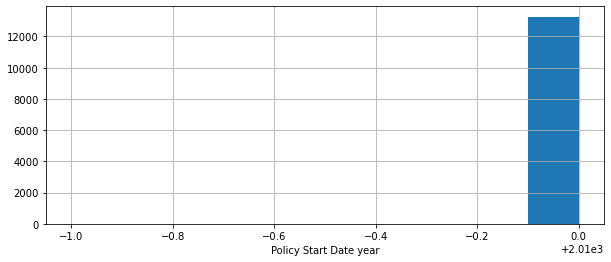

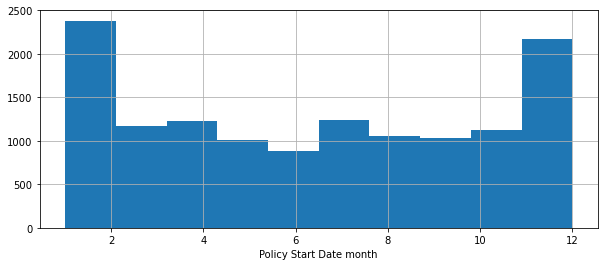

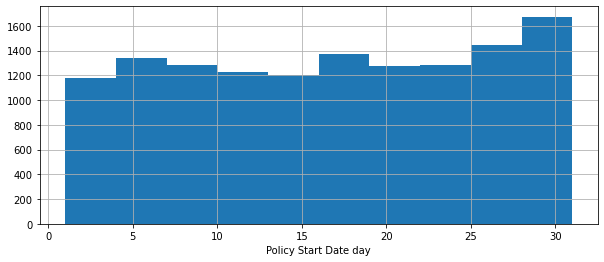

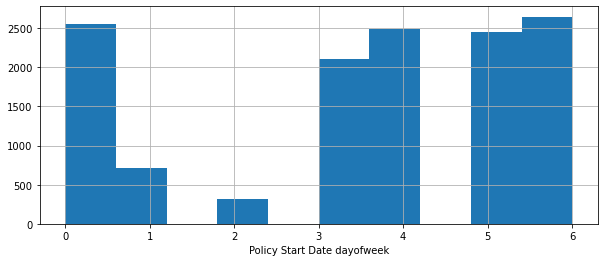

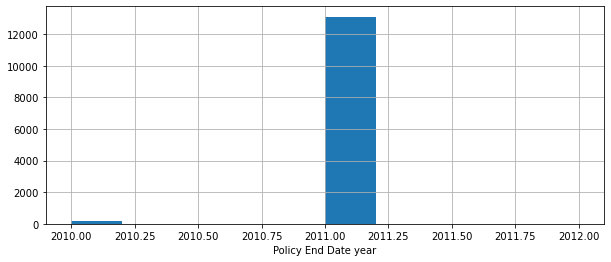

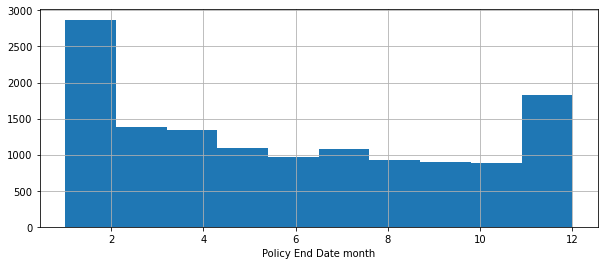

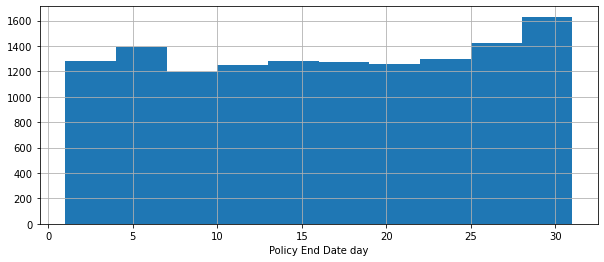

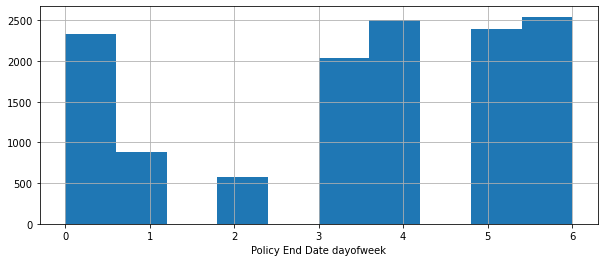

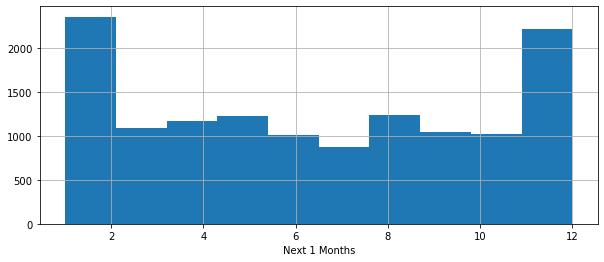

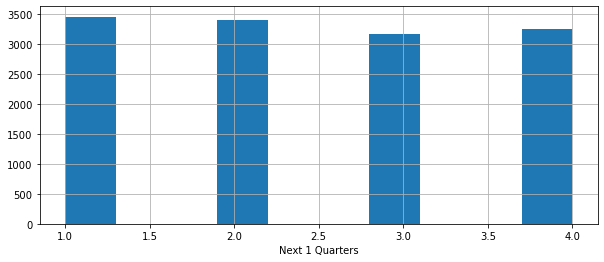

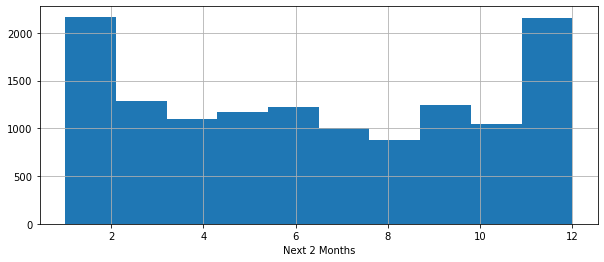

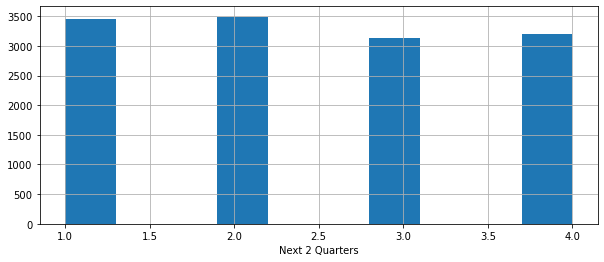

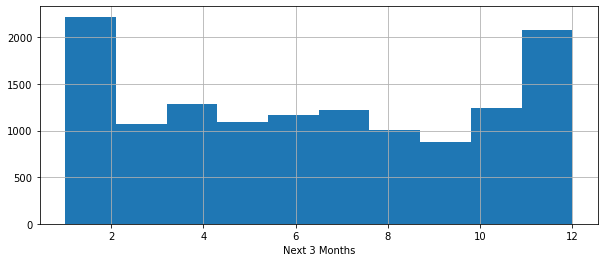

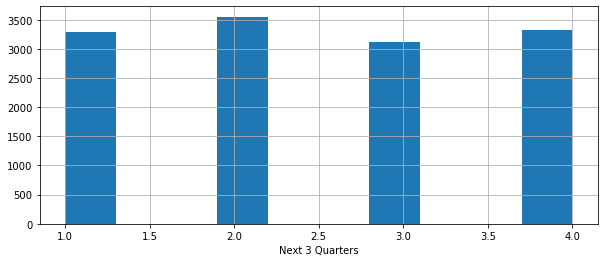

In [836]:
#Numerical histogram of features

for num in date_cols:
    
    all_data[num].hist(figsize=(10, 4))
    
    plt.xlabel(num)
    
    plt.show()

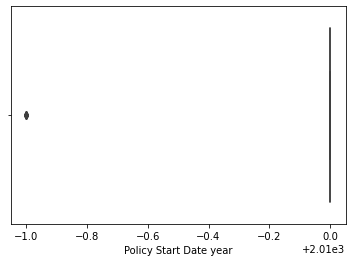

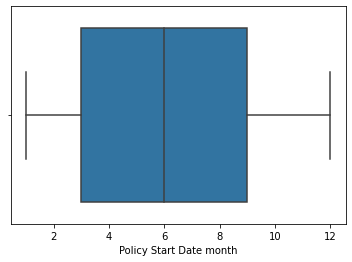

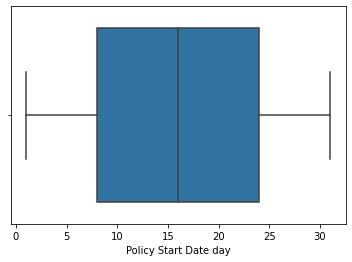

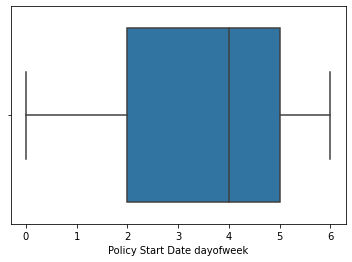

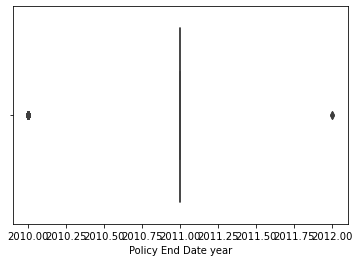

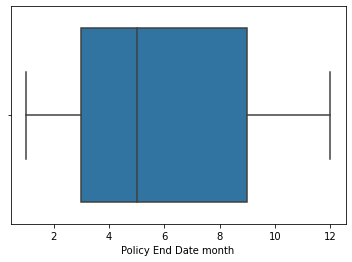

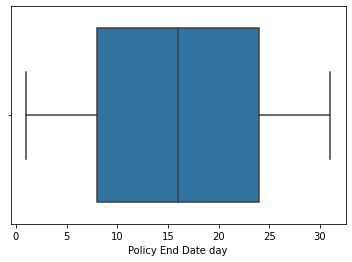

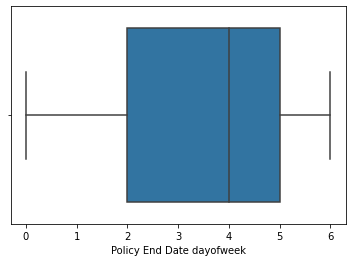

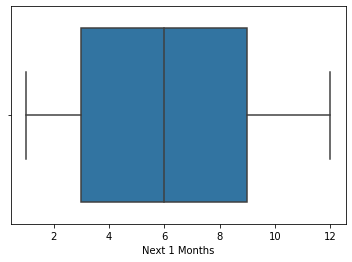

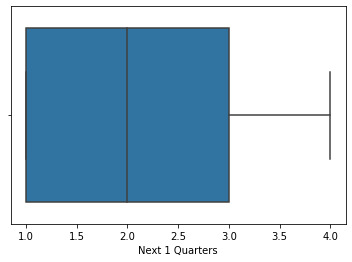

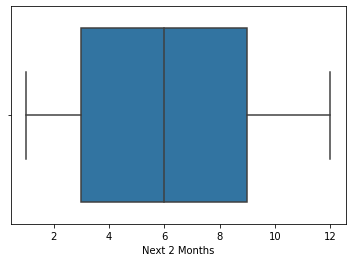

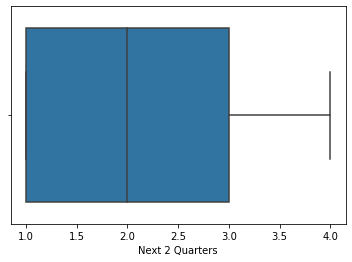

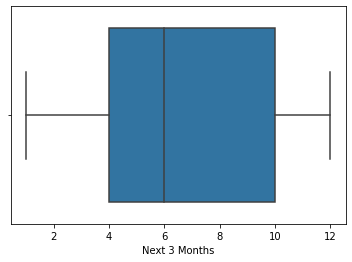

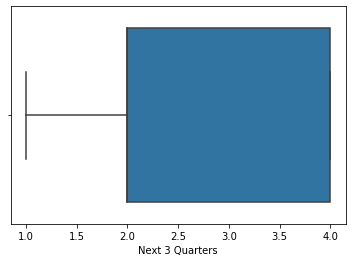

In [837]:
for num in date_cols:
    
    sns.boxplot(all_data[num])
    
    plt.show()

### Categorical Features-

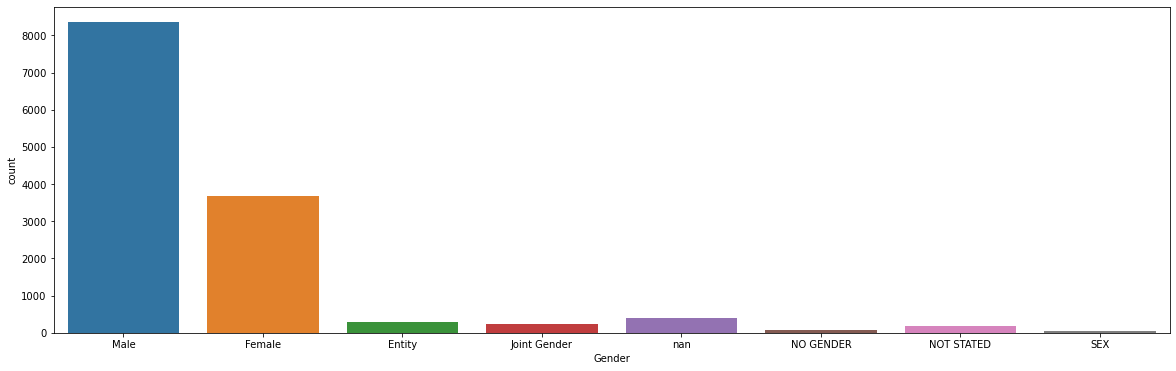

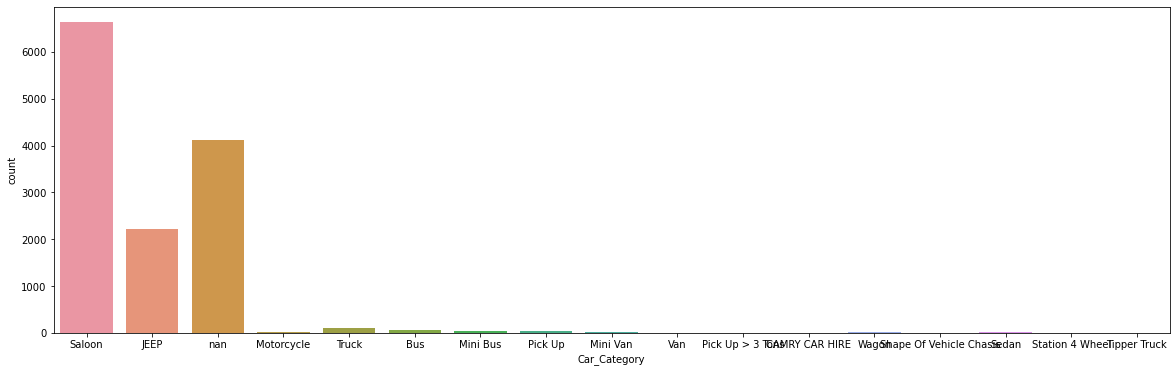

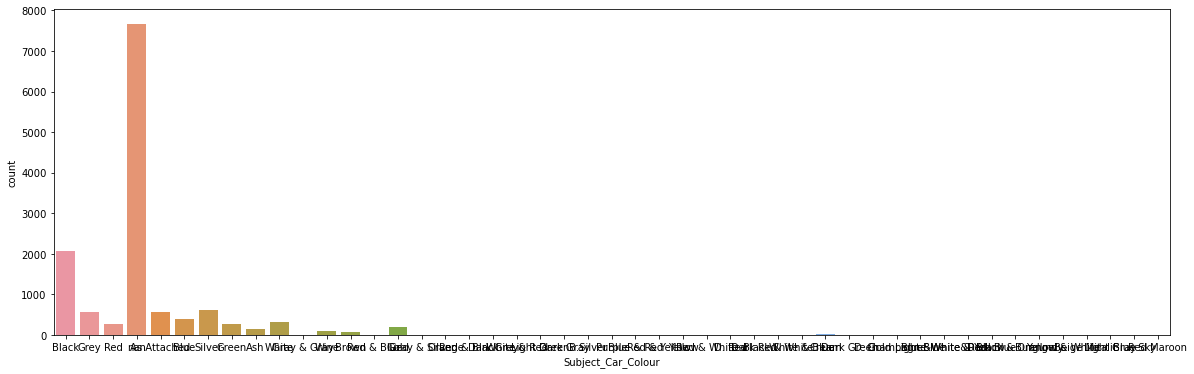

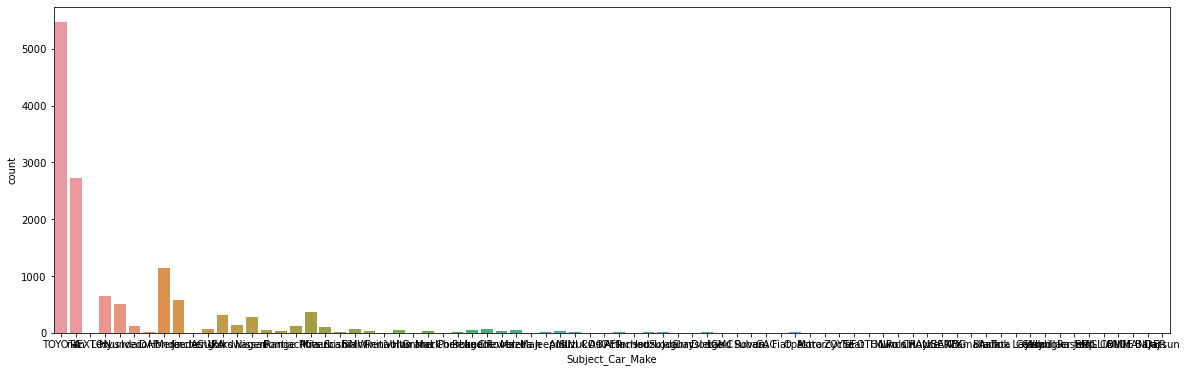

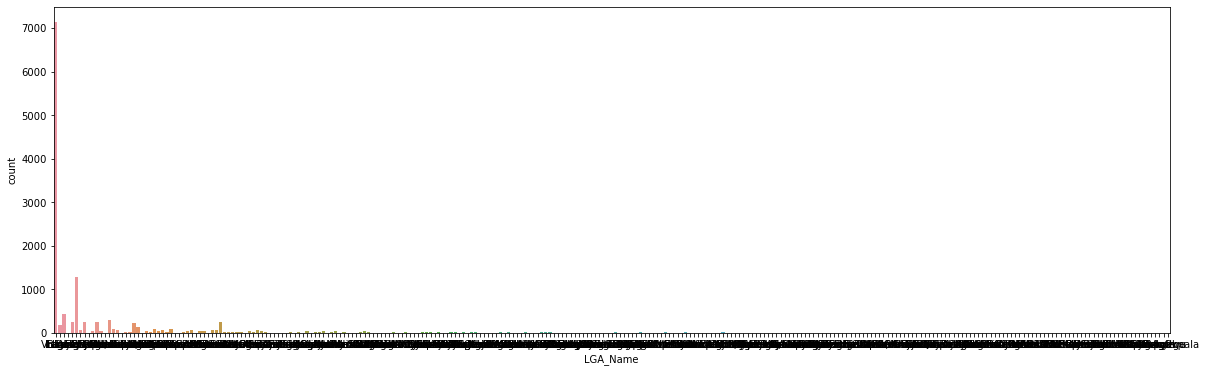

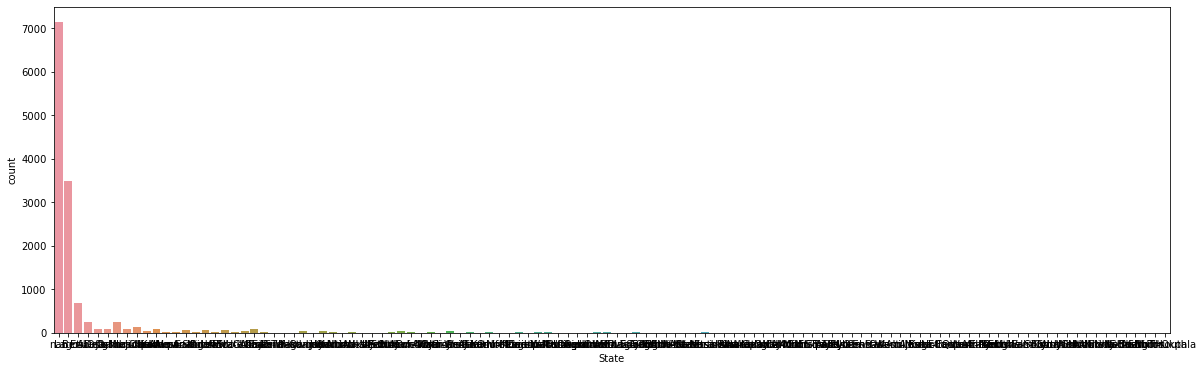

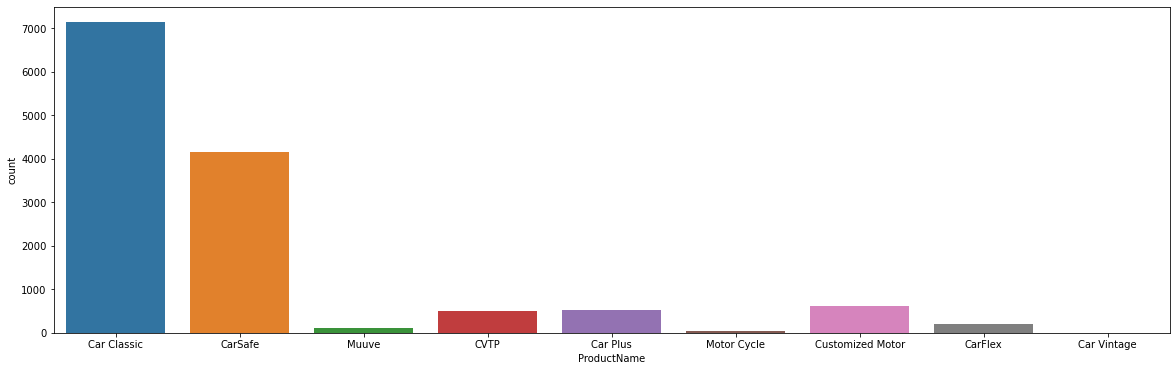

In [838]:
for col in list(cat_cols):
    
    plt.figure(figsize = (20, 6))
    
    sns.countplot(all_data[col])
    
    plt.show()

In [839]:
for col in cat_cols:
    
    print(col)
    
    print ('-----' * 10)
    
    print(all_data[col].value_counts())
          
    print('-----' * 20)

Gender
--------------------------------------------------
Male            8356
Female          3679
nan              400
Entity           300
Joint Gender     238
NOT STATED       190
NO GENDER         76
SEX               42
Name: Gender, dtype: int64
----------------------------------------------------------------------------------------------------
Car_Category
--------------------------------------------------
Saloon                     6633
nan                        4110
JEEP                       2223
Truck                       108
Bus                          56
Mini Bus                     45
Pick Up                      32
Motorcycle                   18
Sedan                        14
Mini Van                     13
Wagon                        10
Shape Of Vehicle Chasis       6
Station 4 Wheel               6
Van                           3
Pick Up > 3 Tons              2
Tipper Truck                  1
CAMRY CAR HIRE                1
Name: Car_Category, dtype: int64
-----

Several sparse categories can be re-grouped after EDA.

***Explore Gender***

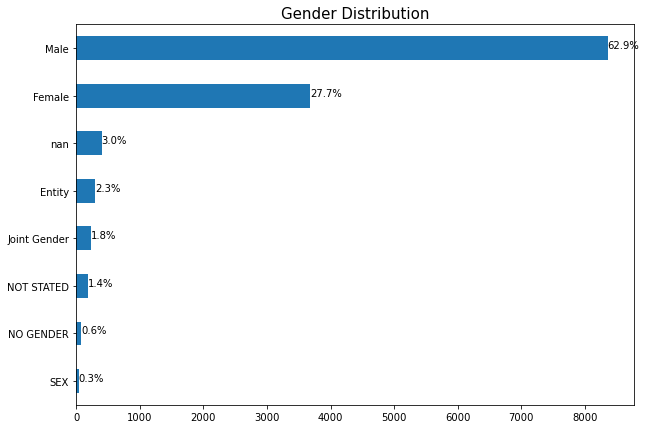

In [840]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

What do the Gender outside Male and Female represent? From domain knowledge, several parties can be assigned to an insurance premium which might represent Entity and Joint Gender.
No Gender, Not stated & Sex can be grouped as missing.

**Transform Gender**

In [841]:
mapper = {'Entity':'nan', 'Joint Gender':'nan', 'NOT STATED': 'nan', 'NO GENDER': 'nan', 'SEX': 'nan'}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
nan       1246
Name: Gender, dtype: int64

In [842]:
#all_data[all_data['Gender'] == 'Group']

***Explore Car Category***

In [843]:
all_data['Car_Category'].value_counts()

Saloon                     6633
nan                        4110
JEEP                       2223
Truck                       108
Bus                          56
Mini Bus                     45
Pick Up                      32
Motorcycle                   18
Sedan                        14
Mini Van                     13
Wagon                        10
Shape Of Vehicle Chasis       6
Station 4 Wheel               6
Van                           3
Pick Up > 3 Tons              2
Tipper Truck                  1
CAMRY CAR HIRE                1
Name: Car_Category, dtype: int64

In [844]:
all_data['Car_Category'] = all_data['Car_Category'].replace({'CAMRY CAR HIRE': 'Saloon', 'Tipper Truck' : 'Truck', \
                                                            'Pick Up > 3 Tons' : 'Pick Up', \
                                                            'Mini Van' : 'Van', 'Shape Of Vehicle Chasis' : 'nan', \
                                                            'Station 4 Wheel' : 'Wagon'})

***Explore Subject_Car_Make***

In [845]:
all_data['Subject_Car_Make'].value_counts()

TOYOTA        5466
nan           2724
Honda         1146
Lexus          654
Mercedes       577
              ... 
Yamaha           1
Caddillac        1
BRILLIANCE       1
Raston           1
Bajaj            1
Name: Subject_Car_Make, Length: 76, dtype: int64

Investigate Categories with few examples

In [846]:
def replace_few(col):
    
    few_makes = list(all_data[col].value_counts()[all_data[col].value_counts() < 4].index)
    
    for make in few_makes:

        all_data.loc[all_data[col] == make, col] = 'low frequency others'
    
    
    
    

In [847]:
all_data['Subject_Car_Make'] = all_data['Subject_Car_Make'].replace('.', 'nan')

In [848]:
replace_few('Subject_Car_Make')

***Explore ProductName***

In [849]:
all_data['ProductName'].value_counts()

Car Classic         7142
CarSafe             4154
Customized Motor     605
Car Plus             523
CVTP                 509
CarFlex              194
Muuve                100
Motor Cycle           49
Car Vintage            5
Name: ProductName, dtype: int64

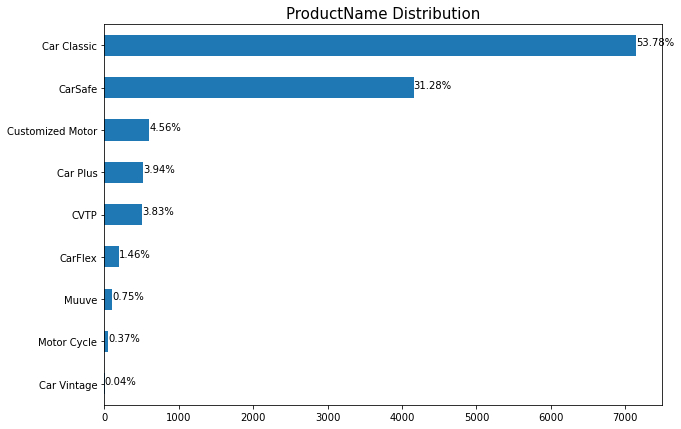

In [850]:
# ProdutName distribution 
ax = all_data.ProductName.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('ProductName Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.2f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

Motor Cycle product name is same for Car_Category. Possibly use to fillna. Explore Bi-variate relationships further.

**Explore Subject_Car_Colour**

In [851]:
list(all_data['Subject_Car_Colour'].value_counts().index)

['nan',
 'Black',
 'Silver',
 'Grey',
 'As Attached',
 'Blue',
 'White',
 'Red',
 'Green',
 'Gold',
 'Ash',
 'Wine',
 'Brown',
 'Cream',
 'Yellow',
 'Dark Gray',
 'White & Blue',
 'Orange',
 'Red & White',
 'Purple',
 'B.Silver',
 'Dark Grey',
 'Blue & Red',
 'D. Red',
 'Light Green',
 'Red & Black',
 'Gray & Silver',
 'Black & Orange',
 'Black & White',
 'White & Red',
 'Dark Blue',
 'Gray & Gray',
 'Burgundy',
 'D. Gold',
 'Light Gray',
 'Dark Green',
 'Yellow & White',
 'Red & Yellow',
 'Light Blue',
 'White & Yellow',
 'Red Maroon',
 'Blue&White&Red',
 'Red & Blue',
 'Champagne',
 'Blue Sky',
 'Beige Mitalic',
 'Dark Red']

Color features will be better one-hot encoded to represent the different conditions of a car colour where it can be a certain shade and a color, or just that color or just a shade.

In [852]:
all_data.loc[all_data.Subject_Car_Colour == 'As Attached', 'Subject_Car_Colour'] = 'nan'

**Create Color groups**

In [853]:
def create_color_group(df):
    
    if df in ['Black', 'Silver', 'Grey', 'White', 'Ash', 'Gold', 'Brown', 'Cream', 'Light Gray', 'D. Gold', 'Dark Gray', \
             'B.Silver', 'Dark Grey', 'Beige Mitalic']:
        
        return 'single neutral'
    
    elif df == 'nan':
        
        return 'nan'
    
    
    elif '&' in df:
        
        return 'multi-color'
    
    
    else:
        
        return 'single non-neutral'

In [854]:
all_data['color_group'] = all_data['Subject_Car_Colour'].apply(create_color_group)

In [855]:
#Normalize Car color

all_data['Subject_Car_Colour'] = all_data['Subject_Car_Colour'].str.replace(r"D\.", ' Dark ')

all_data['Subject_Car_Colour'] = all_data['Subject_Car_Colour'].str.replace(r"B\.", ' Bright ')

all_data['Subject_Car_Colour'] = all_data['Subject_Car_Colour'].str.replace(r"Gray", 'Grey ')


In [856]:
all_data['Subject_Car_Colour'] = all_data['Subject_Car_Colour'].str.strip()

In [857]:
all_data['Subject_Car_Colour'].unique()

array(['Black', 'Grey', 'Red', 'nan', 'Blue', 'Silver', 'Green', 'Ash',
       'White', 'Grey  & Grey', 'Wine', 'Brown', 'Red & Blue', 'Gold',
       'Grey  & Silver', 'Orange', 'Red & Black', 'Dark Grey',
       'White & Red', 'Light Green', 'Bright Silver', 'Purple',
       'Blue & Red', 'Red & Yellow', 'Yellow', 'Red & White', 'Dark  Red',
       'Dark Red', 'Black & White', 'White & Blue', 'Cream', 'Dark Green',
       'Dark  Gold', 'Champagne', 'Light Blue', 'Blue&White&Red',
       'White & Yellow', 'Dark Blue', 'Black & Orange', 'Burgundy',
       'Yellow & White', 'Beige Mitalic', 'Light Grey', 'Blue Sky',
       'Red Maroon'], dtype=object)

In [858]:
def split_colors(df):
    
        if len(df.split('&')) > 1:
        
            return df.split('&')
    
        else:
        
            return df.split(' ')
        
    
        

In [859]:
all_data['Subject_Car_Colour'] = all_data['Subject_Car_Colour'].apply(split_colors)

In [860]:
all_colors = list(all_data['Subject_Car_Colour'].value_counts().index)

In [861]:
all_colors

[['nan'],
 ['Black'],
 ['Silver'],
 ['Grey'],
 ['Blue'],
 ['White'],
 ['Red'],
 ['Green'],
 ['Gold'],
 ['Ash'],
 ['Wine'],
 ['Brown'],
 ['Dark', 'Grey'],
 ['Cream'],
 ['Yellow'],
 ['Orange'],
 ['White ', ' Blue'],
 ['Red ', ' White'],
 ['Bright', 'Silver'],
 ['Purple'],
 ['Dark', '', 'Red'],
 ['Blue ', ' Red'],
 ['Light', 'Green'],
 ['Black ', ' White'],
 ['White ', ' Red'],
 ['Dark', 'Blue'],
 ['Red ', ' Black'],
 ['Black ', ' Orange'],
 ['Grey  ', ' Silver'],
 ['Grey  ', ' Grey'],
 ['Red ', ' Blue'],
 ['Light', 'Grey'],
 ['Blue', 'Sky'],
 ['Beige', 'Mitalic'],
 ['Yellow ', ' White'],
 ['Red', 'Maroon'],
 ['Dark', 'Red'],
 ['Dark', 'Green'],
 ['Dark', '', 'Gold'],
 ['Champagne'],
 ['Light', 'Blue'],
 ['Blue', 'White', 'Red'],
 ['White ', ' Yellow'],
 ['Burgundy'],
 ['Red ', ' Yellow']]

In [862]:
#Extracting colors

subject_colors = list()

for index in all_colors:
    
    if index == 'low frequency others colors':
    
        subject_colors.append(index)
        
        pass
    
    else:
        
        for col in index:
            
            if col == 'nan':
                
                pass
            
            else: 
        
                subject_colors.append(col)
        
        
    
    

In [863]:
subject_colors

['Black',
 'Silver',
 'Grey',
 'Blue',
 'White',
 'Red',
 'Green',
 'Gold',
 'Ash',
 'Wine',
 'Brown',
 'Dark',
 'Grey',
 'Cream',
 'Yellow',
 'Orange',
 'White ',
 ' Blue',
 'Red ',
 ' White',
 'Bright',
 'Silver',
 'Purple',
 'Dark',
 '',
 'Red',
 'Blue ',
 ' Red',
 'Light',
 'Green',
 'Black ',
 ' White',
 'White ',
 ' Red',
 'Dark',
 'Blue',
 'Red ',
 ' Black',
 'Black ',
 ' Orange',
 'Grey  ',
 ' Silver',
 'Grey  ',
 ' Grey',
 'Red ',
 ' Blue',
 'Light',
 'Grey',
 'Blue',
 'Sky',
 'Beige',
 'Mitalic',
 'Yellow ',
 ' White',
 'Red',
 'Maroon',
 'Dark',
 'Red',
 'Dark',
 'Green',
 'Dark',
 '',
 'Gold',
 'Champagne',
 'Light',
 'Blue',
 'Blue',
 'White',
 'Red',
 'White ',
 ' Yellow',
 'Burgundy',
 'Red ',
 ' Yellow']

In [864]:
subject_colors = [s.strip() for s in subject_colors]

In [865]:
subject_colors

['Black',
 'Silver',
 'Grey',
 'Blue',
 'White',
 'Red',
 'Green',
 'Gold',
 'Ash',
 'Wine',
 'Brown',
 'Dark',
 'Grey',
 'Cream',
 'Yellow',
 'Orange',
 'White',
 'Blue',
 'Red',
 'White',
 'Bright',
 'Silver',
 'Purple',
 'Dark',
 '',
 'Red',
 'Blue',
 'Red',
 'Light',
 'Green',
 'Black',
 'White',
 'White',
 'Red',
 'Dark',
 'Blue',
 'Red',
 'Black',
 'Black',
 'Orange',
 'Grey',
 'Silver',
 'Grey',
 'Grey',
 'Red',
 'Blue',
 'Light',
 'Grey',
 'Blue',
 'Sky',
 'Beige',
 'Mitalic',
 'Yellow',
 'White',
 'Red',
 'Maroon',
 'Dark',
 'Red',
 'Dark',
 'Green',
 'Dark',
 '',
 'Gold',
 'Champagne',
 'Light',
 'Blue',
 'Blue',
 'White',
 'Red',
 'White',
 'Yellow',
 'Burgundy',
 'Red',
 'Yellow']

In [866]:
subject_colors = list(set(subject_colors))

In [867]:
subject_colors

['Blue',
 '',
 'Ash',
 'Bright',
 'Mitalic',
 'White',
 'Gold',
 'Champagne',
 'Sky',
 'Wine',
 'Beige',
 'Burgundy',
 'Orange',
 'Dark',
 'Grey',
 'Black',
 'Green',
 'Light',
 'Brown',
 'Silver',
 'Maroon',
 'Red',
 'Yellow',
 'Cream',
 'Purple']

In [868]:
subject_colors.remove('')

In [869]:
subject_colors

['Blue',
 'Ash',
 'Bright',
 'Mitalic',
 'White',
 'Gold',
 'Champagne',
 'Sky',
 'Wine',
 'Beige',
 'Burgundy',
 'Orange',
 'Dark',
 'Grey',
 'Black',
 'Green',
 'Light',
 'Brown',
 'Silver',
 'Maroon',
 'Red',
 'Yellow',
 'Cream',
 'Purple']

In [870]:
#Create one hot encoded features

all_data[subject_colors] = 0

In [871]:
all_data['Subject_Car_Colour'] = all_data['Subject_Car_Colour'].fillna('nan')

In [872]:
#Assign one hot features for car colors

for ind in tqdm(range(len(all_data['Subject_Car_Colour']))):
    
    for color in all_data['Subject_Car_Colour'].iloc[ind]:
        
        if str(color) in subject_colors:
            
            all_data[color].iloc[ind] = 1
                
    

100%|██████████████████████████████████████████████████████████████████████████| 13281/13281 [00:01<00:00, 8043.49it/s]


In [873]:
#Drop the uneeded car color column

all_data.drop(['Subject_Car_Colour'], axis = 1, inplace = True)

In [874]:
cols = all_data[['Burgundy', 'Brown', 'Gold', 'Yellow', 'Grey', 'Silver', 'Maroon',
       'Red', 'Champagne', 'Green', 'Bright', 'Beige', 'Light', 'Dark',
       'Black', 'Sky', 'Mitalic', 'Purple', 'Ash', 'Cream', 'White', 'Orange',
       'Blue', 'Wine']].sum()

low_cols = list(cols[cols < 4].index)

In [875]:
all_data = all_data.drop(low_cols, axis = 1)

**Explore State**

In [876]:
states

,LGA,State
0,Abadam,Borno State
1,Abaji,Federal Capital Territory
2,Abak,Akwa Ibom State
3,Abakaliki,Ebonyi State
4,Aba-North,Abia State
...,...,...
870,Warri,Warri-South-West
871,Warri-Central,Warri-South
872,Wuse-11,Abuja-Municipal-Area-Council
873,Yaba,Lagos-Mainland


In [877]:
all_data['State'].value_counts().sort_values()

ENUGU-SOUTH           1
Essien-Udim           1
Akoko-West            1
Oshimili-North        1
Isoko-south           1
                   ... 
Eti-Osa             241
Abuja-Municipal     257
Benue               693
Lagos              3494
nan                7144
Name: State, Length: 114, dtype: int64

In [878]:
#States in Nigeria

states_ng = ['Abuja','Abia','Adamawa','Akwa Ibom','Anambra','Bauchi','Bayelsa','Benue','Borno','Cross River','Delta', 'Ebonyi','Edo',
'Enugu','Ekiti','Gombe','Imo','Jigawa','Kaduna','Kano','Zamfara','Yobe','Taraba','Sokoto','Rivers','Plateau','Oyo',
'Osun','Ondo','Ogun','Niger','Nassarawa','Lagos','Kwara','Kogi','Kebbi','Katsina']

In [879]:
list(all_data['State'].value_counts().sort_values().index)

['ENUGU-SOUTH',
 'Essien-Udim',
 'Akoko-West',
 'Oshimili-North',
 'Isoko-south',
 'Ndokwa-East',
 'Nnewi-South',
 'Ogba-Ndoni',
 'Kebbi',
 'Ethiope-East',
 'Ughelli-North',
 'QuaAn-Pan',
 'Owerri-North',
 'Ovia-SouthWest',
 'Ekiti-West',
 'Ngor-Okpala',
 'N-A',
 'Aba-South',
 'Bauchi',
 'Idemili-south',
 'Asari-Toru',
 'Ijebu-East',
 'Awka-North',
 'Isoko-North',
 'Bayelsa',
 'Oyo-West',
 'Nasarawa',
 'Ijebu-North',
 'Ilesha-East',
 'Ajegunle-State',
 'Calabar-Municipality',
 'Oyo-East',
 'Ekiti-East',
 'Orile-Iganmu',
 'Ile-Oluji',
 'Central-Abuja',
 'Ibarapa-Central',
 'Idemili-North',
 'Owerri-West',
 'Ilorin-East',
 'Ondo-West',
 'Kano',
 'Ado-Ekiti',
 'Ebonyi',
 'Warri-South',
 'Abia',
 'Onitsha-South',
 'Umuahia-South',
 'Esan-Central',
 'Kogi',
 'Aboh-Mbaise',
 'AJAO-ESTATE',
 'Ilorin-West',
 'Esan-West',
 'Ife-North',
 'Warri-North',
 'Udi-Agwu',
 'Gombe',
 'Aniocha-South',
 'Nsit-Ubium',
 'Kwara',
 'Ado-Ota',
 'Ilesha-West',
 'Onitsha-North',
 'Cross-River',
 'Ogun-Waterside'

**States Normalization**

In [880]:
lagos_zone = ['Eti-Osa','Ibeju-Lekki','Oshodi-Isolo','Amuwo-Odofin',
              'Ifako-Ijaye','Ajeromi-Ifelodun','ABULE-EGBA','AJAO-ESTATE',
             'Orile-Iganmu','Ajegunle-State']

ogun_zone = ['Ijebu-Ode','Ado-Ota','Ogun-Waterside','Obafemi-Owode','Ijebu-East','Ijebu-North']

oyo_zone = ['Ibadan-West','Ibadan-East','Ogbmosho-South','Lagelu-North',
            'Ibadan-North','Oyo-West','Oyo-East','Ibarapa-Central']

osun_zone = ['Ilesha-East','Ilesha-West','Ife-North','Ife-Central']

ondo_zone = ['Ondo-West','Ile-Oluji','Akoko-West']

ekiti_zone = ['Ekiti-West','Ekiti-East','Ado-Ekiti']

edo_zone = ['Ovia-SouthWest','Esan-Central','Esan-West','Etsako-West']

abia_zone = ['Umuahia-South','Aba-North','Aba-South']

delta_zone = ['Warri-Central','Aniocha-South','Warri-North',
              'Warri-South','Ndokwa-East','Isoko-North','Isoko-south',
             'Ughelli-North','Ethiope-East','Oshimili-North']

rivers_zone = ['Obia-Akpor','Port-Harcourt','Asari-Toru','Ogba-Ndoni']

enugu_zone = ['ENUGU-EAST','Enugu-North','Udi-Agwu','ENUGU-SOUTH']

imo_zone = ['Owerri-Municipal','Owerri-West','Aboh-Mbaise','Owerri-North','Ngor-Okpala']

anambra_zone = ['Anambra-East','Nnewi-North','Idemili-North','Nnewi-South','Idemili-south', 'Nwewi-South','Awka-North','Onitsha-South',
                'Onitsha-North','Awka-South','Anambra-East']

akwa_zone = ['Nsit-Ubium','Essien-Udim']

cross_zone = ['Calabar-Municipality']

abuja_zone = ['Abuja-Municipal','Central-Abuja']

kaduna_zone = ['Kaduna-North','Kaduna-South']

plat_zone = ['Jos-North','Jos-South','QuaAn-Pan']

kwara_zone = ['Ilorin-East','Ilorin-North','Ilorin-West']



In [881]:
state_zones = [lagos_zone, ogun_zone, oyo_zone, osun_zone, ondo_zone, ekiti_zone, edo_zone, abia_zone, delta_zone, \
               rivers_zone, enugu_zone, imo_zone, anambra_zone, akwa_zone, cross_zone, \
               abuja_zone, kaduna_zone, plat_zone, kwara_zone]

states = ['Lagos', 'Ogun', 'Oyo', 'Osun', 'Ondo', 'Ekiti', 'Edo', 'Abia', 'Delta', 'Rivers', 'Enugu', 'Imo', 'Anambra', \
          'Akwa-Ibom', 'Cross-River', 'Abuja', 'Kaduna', 'Plateau', 'Kwara']

In [882]:
for state, state_zone in tqdm(zip(states, state_zones)):
    
    all_data['State'] = all_data['State'].replace(state_zone, state)

19it [00:00, 112.49it/s]


In [883]:
all_data['State'].value_counts()

nan               7144
Lagos             4073
Benue              693
Abuja              340
Rivers             204
Delta              138
Ogun               120
Oyo                117
Edo                 78
Anambra             56
Imo                 50
Kaduna              49
Enugu               47
Osun                43
Akwa-Ibom           24
Plateau             24
Ondo                19
Niger-State         14
Abia                 9
Kwara                9
Cross-River          6
Ekiti                5
Kano-Municipal       5
Gombe                3
Kogi                 2
Ebonyi               2
Kano                 2
Bayelsa              1
Bauchi               1
N-A                  1
Nasarawa             1
Kebbi                1
Name: State, dtype: int64

In [884]:
all_data['State'] = all_data['State'].replace('Niger-State','Niger')
all_data['State'] = all_data['State'].replace('Kano-Municipal','Kano')
all_data['State'] = all_data['State'].replace('N-A', 'nan')

In [885]:
all_data['State'].value_counts()

nan            7145
Lagos          4073
Benue           693
Abuja           340
Rivers          204
Delta           138
Ogun            120
Oyo             117
Edo              78
Anambra          56
Imo              50
Kaduna           49
Enugu            47
Osun             43
Plateau          24
Akwa-Ibom        24
Ondo             19
Niger            14
Kwara             9
Abia              9
Kano              7
Cross-River       6
Ekiti             5
Gombe             3
Kogi              2
Ebonyi            2
Bayelsa           1
Bauchi            1
Nasarawa          1
Kebbi             1
Name: State, dtype: int64

In [886]:
all_data['State'].value_counts()

nan            7145
Lagos          4073
Benue           693
Abuja           340
Rivers          204
Delta           138
Ogun            120
Oyo             117
Edo              78
Anambra          56
Imo              50
Kaduna           49
Enugu            47
Osun             43
Plateau          24
Akwa-Ibom        24
Ondo             19
Niger            14
Kwara             9
Abia              9
Kano              7
Cross-River       6
Ekiti             5
Gombe             3
Kogi              2
Ebonyi            2
Bayelsa           1
Bauchi            1
Nasarawa          1
Kebbi             1
Name: State, dtype: int64

**Explore LGA_Name**

In [887]:
all_data['LGA_Name'].value_counts().index[1000:200]

Index([], dtype='object')

In [888]:
all_data['LGA_Name'] = all_data['LGA_Name'].replace('LGA','nan')
all_data['LGA_Name'] = all_data['LGA_Name'].replace('OGUN','Abeokuta-South')
all_data['LGA_Name'] = all_data['LGA_Name'].replace('ONDO','Akure-North')
all_data['LGA_Name'] = all_data['LGA_Name'].replace('RIVERS','Port-Harcourt')
all_data['LGA_Name'] = all_data['LGA_Name'].replace(['Ikeja G.R.A','Lagos'],'Ikeja')
all_data['LGA_Name'] = all_data['LGA_Name'].replace('State', 'nan')

In [889]:
all_data['LGA_Name'].value_counts()

nan                7145
Victoria Island    1284
Ikeja               625
Surulere            306
Abuja Municipal     257
                   ... 
Nnewi South           1
Ilesha East           1
Bekwara               1
AWOYAYA               1
IJAIYE                1
Name: LGA_Name, Length: 267, dtype: int64

In [890]:
all_data.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName', 'target', 'tag',
       'Policy Start Date year', 'Policy Start Date month',
       'Policy Start Date day', 'Policy Start Date dayofweek',
       'Policy End Date year', 'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'weekinmonth', 'Policy_delta',
       'Date Next 1 Months', 'Next 1 Months', 'Next 1 Quarters',
       'Date Next 2 Months', 'Next 2 Months', 'Next 2 Quarters',
       'Date Next 3 Months', 'Next 3 Months', 'Next 3 Quarters', 'summer',
       'winter', 'spring', 'autumn', 'Policy_isfestive', 'color_group', 'Blue',
       'Ash', 'Bright', 'White', 'Gold', 'Wine', 'Orange', 'Dark', 'Grey',
       'Black', 'Green', 'Light', 'Brown', 'Silver', 'Red', 'Yellow', 'Cream',
       'Purple'],
      dtype='object')

**Normalize state & LGA due to data entry non-uniformity:**

In [891]:
def remove_punctuations(df):
    
    for punc in string.punctuation:
        
        if type(df) == str:
            
            df = df.replace(punc, ' ')
            
        else:
            
            pass
        
    return df
        
        

In [892]:
import string
    
all_data['LGA_Name'] = all_data['LGA_Name'].str.lower()
    
all_data['LGA_Name'] = all_data['LGA_Name'].apply(remove_punctuations)
    

In [893]:
list(all_data['LGA_Name'].value_counts().index)

['nan',
 'victoria island',
 'ikeja',
 'surulere',
 'abuja municipal',
 'lagos mainland',
 'lagos island',
 'eti osa',
 'lekki',
 'ibeju lekki',
 'port harcourt',
 'obia akpor',
 'oshodi isolo',
 'kosofe',
 'abuja',
 'alimosho',
 'apapa',
 'benin',
 'ikoyi',
 'amuwo odofin',
 'shomolu',
 'ikorodu',
 'agege',
 'ajah',
 'warri',
 'abeokuta south',
 'gbagada',
 'yaba',
 'festac',
 'ifako ijaye ',
 'enugu east',
 'abeokuta',
 'warri central',
 'ibadan north west',
 'ogba',
 'isolo',
 'isheri',
 'central',
 'asaba',
 'ketu',
 'ilupeju',
 'kaduna north',
 'oredo',
 'ifo',
 'ipaja',
 'ibadan south west',
 'ogudu',
 'oguta',
 'egbeda',
 'ojodu',
 'mushin',
 'ibadan north east',
 'ibadancentral',
 'osogbo',
 'oshodi',
 'ife central',
 'owerri municipal',
 'maryland',
 'uyo',
 'jos north',
 'ojo',
 'nnewi',
 'kaduna',
 'shagamu',
 'magodo',
 'owerri',
 'enugu north',
 'jos south',
 'kaduna south',
 'ijebu ode',
 'ebute metta',
 'anambra east',
 'oyo',
 'anthony village',
 'lagelu ogbomosho north

In [894]:
import string

    
all_data['State'] = all_data['State'].apply(remove_punctuations)
    

In [895]:
list(all_data['State'].value_counts().sort_values().index)

['Kebbi',
 'Bauchi',
 'Bayelsa',
 'Nasarawa',
 'Ebonyi',
 'Kogi',
 'Gombe',
 'Ekiti',
 'Cross River',
 'Kano',
 'Abia',
 'Kwara',
 'Niger',
 'Ondo',
 'Plateau',
 'Akwa Ibom',
 'Osun',
 'Enugu',
 'Kaduna',
 'Imo',
 'Anambra',
 'Edo',
 'Oyo',
 'Ogun',
 'Delta',
 'Rivers',
 'Abuja',
 'Benue',
 'Lagos',
 'nan']

In [896]:
replace_few('LGA_Name') 

In [897]:
all_data['LGA_Name'].value_counts()

nan                7145
victoria island    1284
ikeja               625
surulere            306
abuja municipal     257
                   ... 
ile ife               4
ilesha west           4
onitsha north         4
ukpoba                4
ado odo ota           4
Name: LGA_Name, Length: 131, dtype: int64

Lagos is the most popular state. Rainfall pattern varies across states/regions, can we combine state and month to indicate whether it's a rainy season which can cause more accidents.

Extract features on the riskiness of a state based on road accident and crime frequency

### Bivariate Feature Understanding & Data Preparation:

**Age & Car_Category**

In [898]:
def visualize_distribution(df, col):
    
    ax = df.plot(kind = 'barh', figsize=(10,7))
    plt.title(col + ' Distribution', fontdict={'size': 15})
    
    for p in ax.patches:
        percentage ='{:,.2f}%'.format((p.get_width()/num_cat.sum())*100)
        width, height =p.get_width(),p.get_height()
        x=p.get_x()+width+0.02
        y=p.get_y()+height/2
        ax.annotate(percentage,(x,y))
    #plt.figure(figsize = (20, 5))
    plt.xticks(rotation = 90)

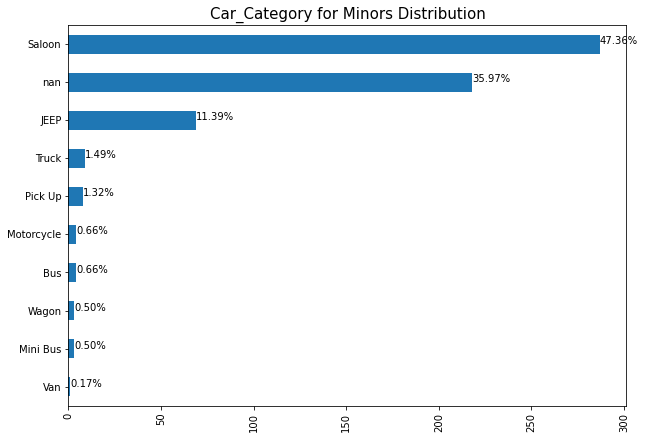

In [899]:
#What cars do minors drive (Legal Age for driving is 18)
num_cat = all_data[all_data.Age < 18]['Car_Category'].value_counts().sort_values()

visualize_distribution(num_cat, 'Car_Category for Minors')

The ages range less than 18 show minors drive trucks, mini van, bus. Definitely this is invalid data, drivers license for minors is usually the smallest grade. We expect minors to drive either cars or jeep.

Check minor range as > 15 but < 18.

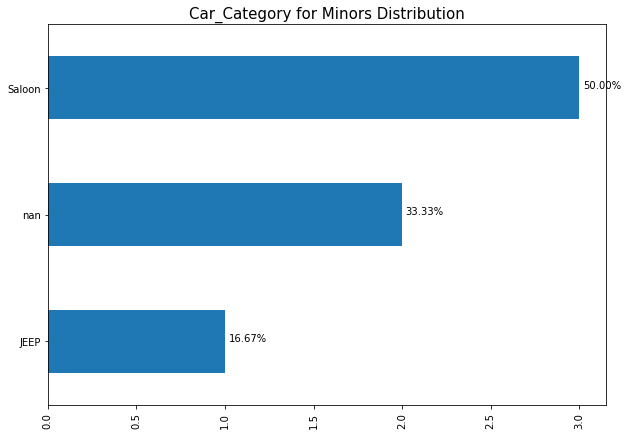

In [900]:
#What cars do real minors drive (Legal Age for driving is 18)
num_cat = all_data[(all_data.Age < 18) & (all_data.Age > 14)]['Car_Category'].value_counts().sort_values()

visualize_distribution(num_cat, 'Car_Category for Minors')

Treat age range less than 15 as invalid data. Take absolute value of Age 

In [901]:
all_data[(all_data['tag'] == 'train') & (all_data['Age'] < -1000)]

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Make,LGA_Name,...,Grey,Black,Green,Light,Brown,Silver,Red,Yellow,Cream,Purple
3427,ID_A3YN75Z,2010-10-02,2011-10-01,nan,-6099,2010-10-02,1,nan,nan,nan,...,0,0,0,0,0,0,0,0,0,0
3518,ID_AE3U4I4,2010-01-16,2011-01-15,Female,-5939,2010-01-16,2,nan,TOYOTA,victoria island,...,0,0,0,0,0,0,0,0,0,0
5173,ID_FKJFVMX,2010-12-14,2011-01-13,Female,-5939,2010-12-14,2,nan,nan,victoria island,...,0,0,0,0,0,0,0,0,0,0


In [902]:
all_data.Age = abs(all_data.Age)

all_data.loc[all_data.Age < 15, 'Age'] = np.nan

In [903]:
all_data['Age'].describe()

count    12692.000000
mean        47.030413
std         93.536193
min         15.000000
25%         35.000000
50%         41.000000
75%         50.000000
max       6099.000000
Name: Age, dtype: float64

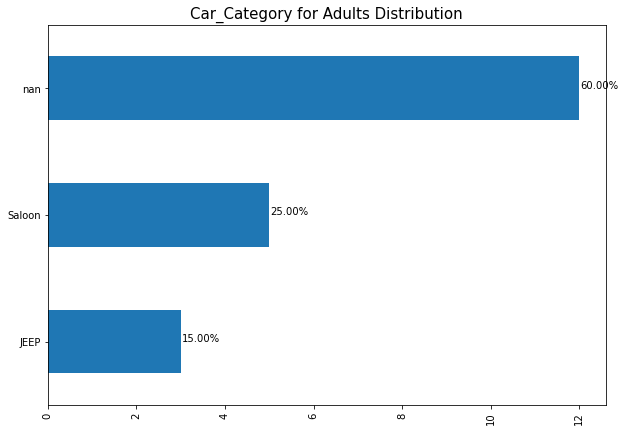

In [904]:
#What cars do people > life expectancy of 120
num_cat = all_data[all_data.Age > 120]['Car_Category'].value_counts().sort_values()
# ProdutName distribution 

visualize_distribution(num_cat, 'Car_Category for Adults')

In [905]:
#Treat as invalid data
all_data.loc[all_data['Age']>120, 'Age'] = 120

**Age & No_Pol**

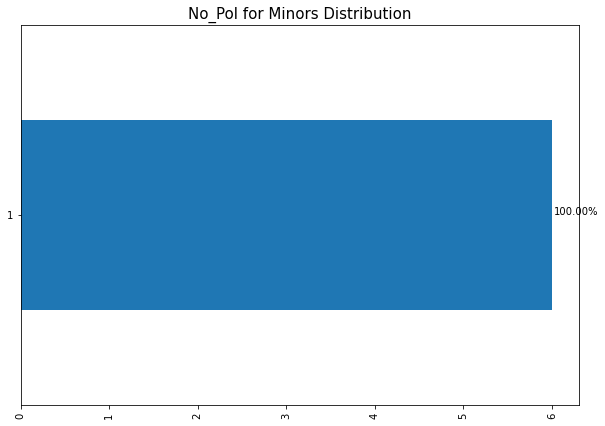

In [906]:
#No of Pol minors
num_cat = all_data[all_data.Age < 18]['No_Pol'].value_counts().sort_values()

visualize_distribution(num_cat, 'No_Pol for Minors')

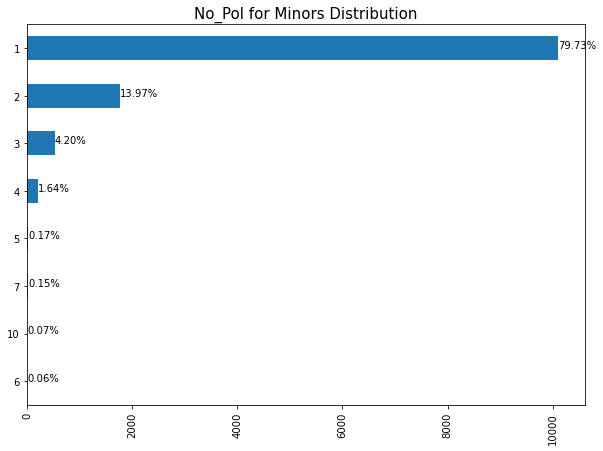

In [907]:
#No of Pol adults
num_cat = all_data[all_data.Age > 18]['No_Pol'].value_counts().sort_values()

visualize_distribution(num_cat, 'No_Pol for Minors')

**Car_Category & Car Make**

In [908]:
all_data.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName', 'target', 'tag',
       'Policy Start Date year', 'Policy Start Date month',
       'Policy Start Date day', 'Policy Start Date dayofweek',
       'Policy End Date year', 'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'weekinmonth', 'Policy_delta',
       'Date Next 1 Months', 'Next 1 Months', 'Next 1 Quarters',
       'Date Next 2 Months', 'Next 2 Months', 'Next 2 Quarters',
       'Date Next 3 Months', 'Next 3 Months', 'Next 3 Quarters', 'summer',
       'winter', 'spring', 'autumn', 'Policy_isfestive', 'color_group', 'Blue',
       'Ash', 'Bright', 'White', 'Gold', 'Wine', 'Orange', 'Dark', 'Grey',
       'Black', 'Green', 'Light', 'Brown', 'Silver', 'Red', 'Yellow', 'Cream',
       'Purple'],
      dtype='object')

In [909]:
list(all_data['Subject_Car_Make'].value_counts().index)

['TOYOTA',
 'nan',
 'Honda',
 'Lexus',
 'Mercedes',
 'Hyundai',
 'Kia',
 'Ford',
 'Nissan',
 'Volkswagen',
 'Iveco',
 'Range Rover',
 'Mitsubishi',
 'ACURA',
 'BMW',
 'Land Rover',
 'Mazda',
 'Peugeot',
 'Volvo',
 'low frequency others',
 'Mack',
 'Audi',
 'Infiniti',
 'Pontiac',
 'Chevrolet',
 'DAF',
 'Skoda',
 'Jeep',
 'Porsche',
 'As Attached',
 'Scania',
 'Suzuki',
 'Opel',
 'Isuzu',
 'Dodge',
 'Renault',
 'Subaru',
 'Land Rover.',
 'GMC',
 'GAC',
 'MINI COOPER',
 'LIBERTY',
 'Man',
 'Jaguar']

In [910]:
#Replace all 'As Attached' as np.nan

all_data = all_data.replace('As Attached', 'nan')

all_data.loc[all_data.Subject_Car_Make == '.', 'Subject_Car_Make'] = 'nan'

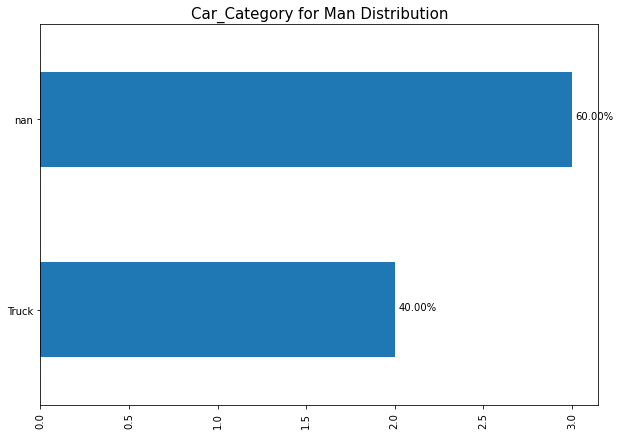

In [911]:
#What does Man mean
num_cat = all_data[all_data.Subject_Car_Make == 'Man']['Car_Category'].value_counts().sort_values()

visualize_distribution(num_cat, 'Car_Category for Man')

**Car_Category & Product Name**

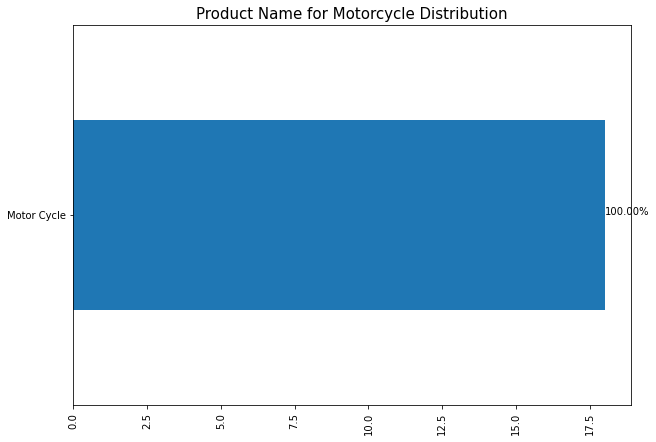

In [912]:
#Motorcycle
num_cat = all_data[all_data.Car_Category == 'Motorcycle']['ProductName'].value_counts().sort_values()

visualize_distribution(num_cat, 'Product Name for Motorcycle')

We can use the 100% direct relationship between Product Name and Car Category to fill missing values for motorcyle.
Motorcycle not a Car Make but a Category.

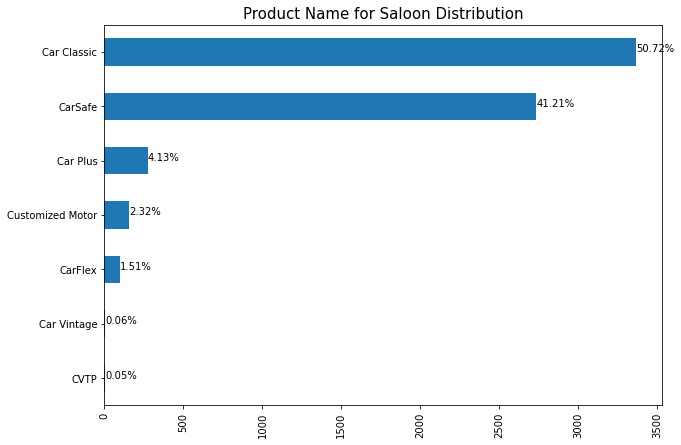

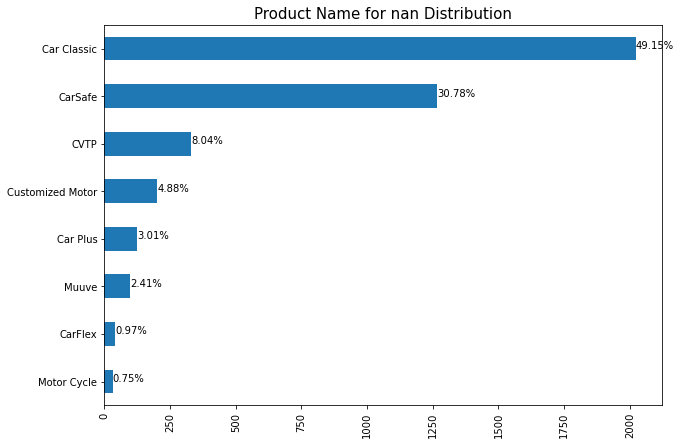

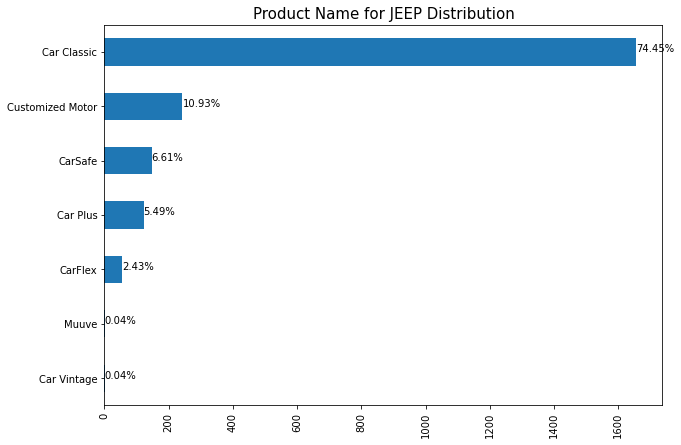

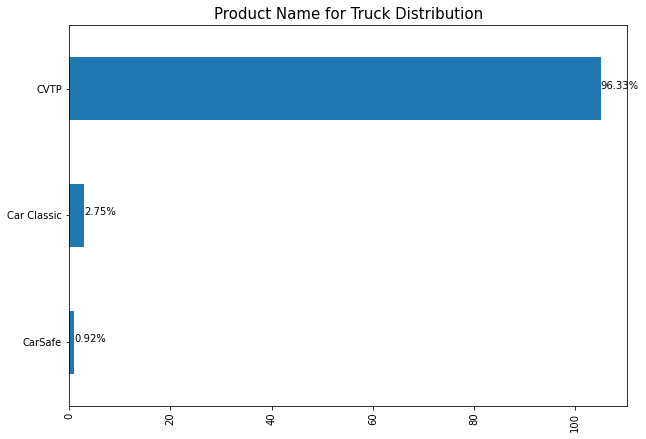

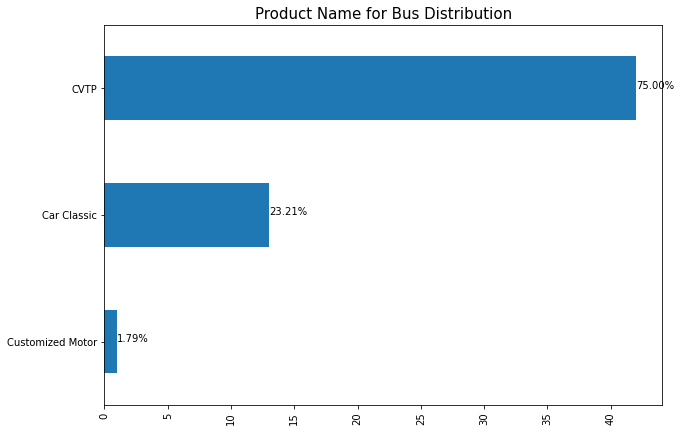

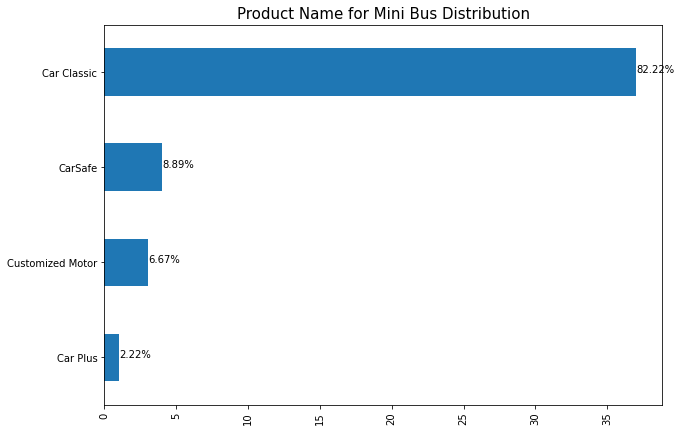

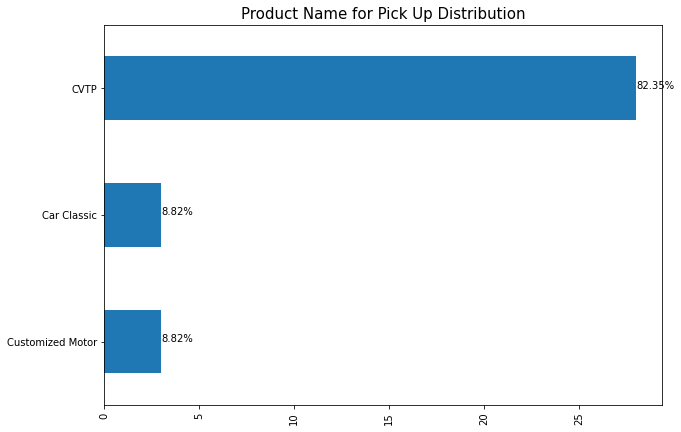

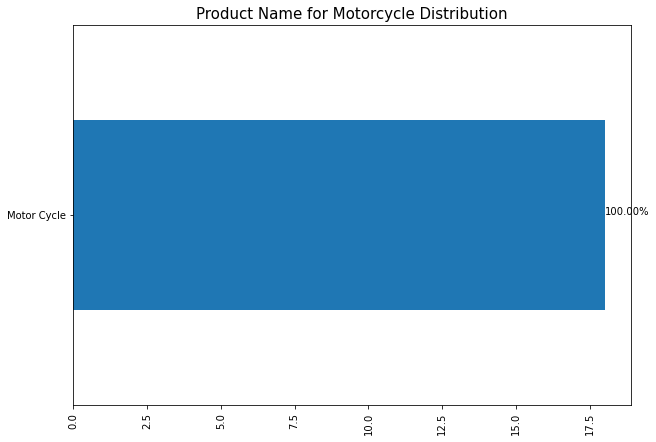

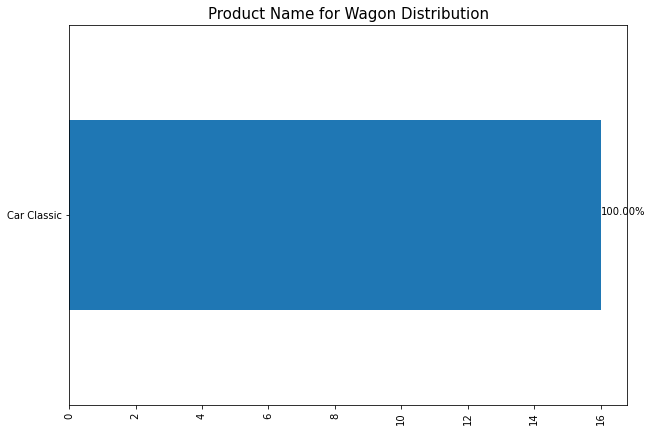

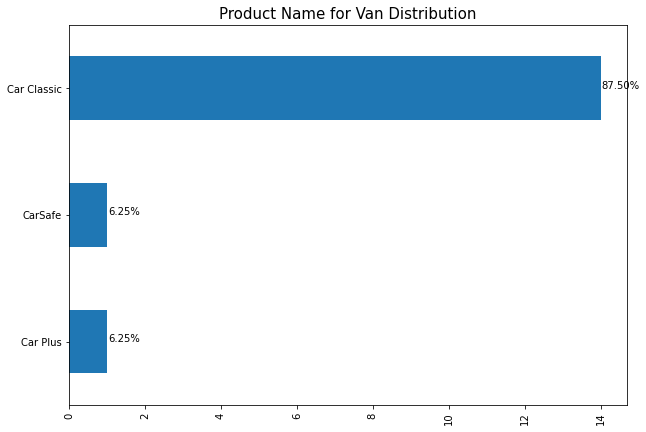

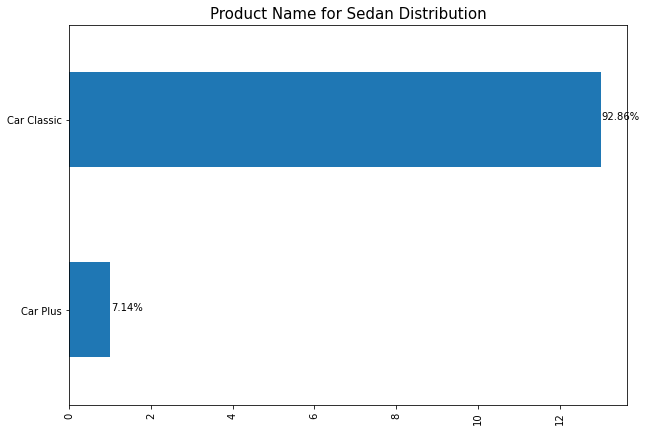

In [913]:
#Visualize product for all categories

for col in list(all_data.Car_Category.value_counts().index):
    
    num_cat = all_data[all_data.Car_Category == col]['ProductName'].value_counts().sort_values()

    visualize_distribution(num_cat, f'Product Name for {col}')
    
    plt.show()

In [914]:
#Replace nan category where product is Motorcycle

all_data.loc[all_data.ProductName == 'Motor Cycle', 'Car_Category'] = 'Motorcycle'

In [915]:
all_data.loc[(all_data.ProductName != 'CVTP') & (all_data.Car_Category == 'Truck')]['tag']


2597     train
10369    train
10599    train
11698    train
Name: tag, dtype: object

Trucks are strongly related to CVTP with Tipper Trucks 100% direct relationship. Investigate trucks not CVTP.

Wagon and Station 4 Wheel highly related to Car Classic. Can we group Station 4 Wheel with Wagon due to small observations in Station 4 Wheel. Also, from domain knowledge it is referred to as Station Wagon.

In test set, all instances of Truck are CVTP. Possibly outlier, we correct this.

In [916]:
#Fix instance of Trucks without CVTP (Test set all CVTP)

all_data.loc[(all_data.ProductName != 'CVTP') & (all_data.Car_Category == 'Truck'), 'ProductName'] = 'CVTP'

In [917]:
all_data['Car_Category'] = all_data['Car_Category'].replace("Station 4 Wheel", 'Wagon')

In [918]:
#Car Category (Grouping similar categories after EDA)

all_data['Car_Category_new'] = all_data['Car_Category'].replace({'Sedan' : 'Car', 'Wagon' : 'Car', 'Saloon' : 'Car', \
                                                                 'Mini Bus' : 'Bus', 'Mini Van' : 'Van'})


**Numerical Correlation**

<AxesSubplot:>

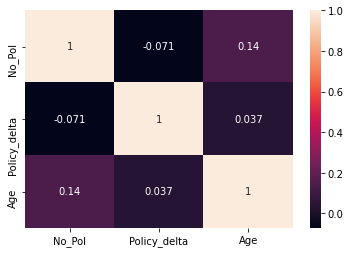

In [919]:
sns.heatmap(all_data[['No_Pol', 'Policy_delta', 'Age']].corr(), annot = True)

Weak correlation, no multi-collinearity. Weak corr btw Age & No Pol

### Target variable Distribution and Relationships

**Categorical**

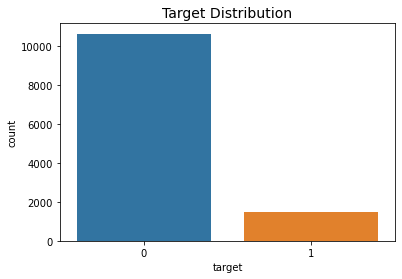

In [920]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

In [921]:
#Drop Dates

all_data = all_data.drop(['First Transaction Date', 'Policy Start Date', 'Policy End Date', 'Date Next 1 Months', 'Date Next 2 Months', 'Date Next 3 Months'], axis = 1)

In [922]:
all_data.columns

Index(['ID', 'Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName', 'target', 'tag',
       'Policy Start Date year', 'Policy Start Date month',
       'Policy Start Date day', 'Policy Start Date dayofweek',
       'Policy End Date year', 'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'weekinmonth', 'Policy_delta',
       'Next 1 Months', 'Next 1 Quarters', 'Next 2 Months', 'Next 2 Quarters',
       'Next 3 Months', 'Next 3 Quarters', 'summer', 'winter', 'spring',
       'autumn', 'Policy_isfestive', 'color_group', 'Blue', 'Ash', 'Bright',
       'White', 'Gold', 'Wine', 'Orange', 'Dark', 'Grey', 'Black', 'Green',
       'Light', 'Brown', 'Silver', 'Red', 'Yellow', 'Cream', 'Purple',
       'Car_Category_new'],
      dtype='object')

In [923]:
cat_cols = ['Gender',  'No_Pol', 'Car_Category_new',
       'Car_Category', 'Subject_Car_Make', 'LGA_Name', 'State', 'ProductName',
       'Policy Start Date year', 'Policy Start Date month',
       'Policy Start Date day', 'Policy Start Date dayofweek',
       'Policy End Date year', 'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'Next 1 Months',
       'Next 1 Quarters', 'Next 2 Months', 'Next 2 Quarters', 'Next 3 Months',
       'Next 3 Quarters', 'summer', 'winter', 'spring',
       'autumn', 'Policy_isfestive', 'color_group', 'Brown', 'Gold', 'Yellow',
       'Grey', 'Silver', 'Red', 'Green', 'Bright', 'Light', 'Dark', 'Black',
       'Purple', 'Ash', 'Cream', 'White', 'Orange', 'Blue', 'Wine',
       ]

In [924]:
#num_cols = 'Age', 'Policy_delta', 

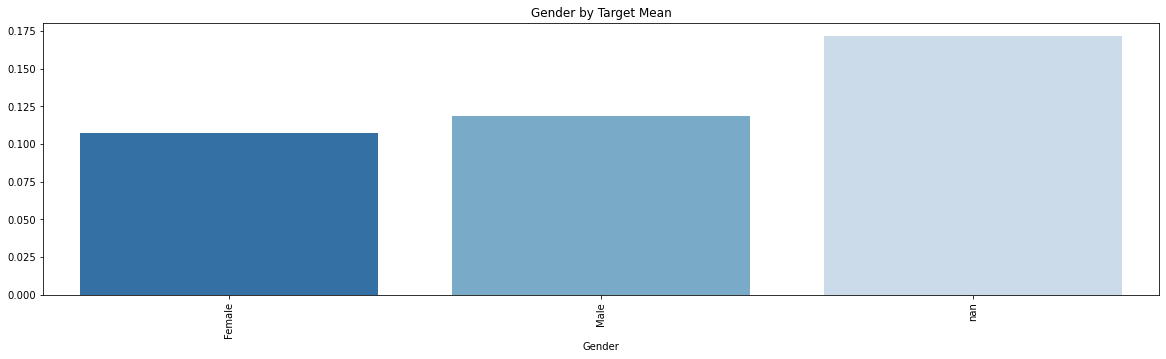

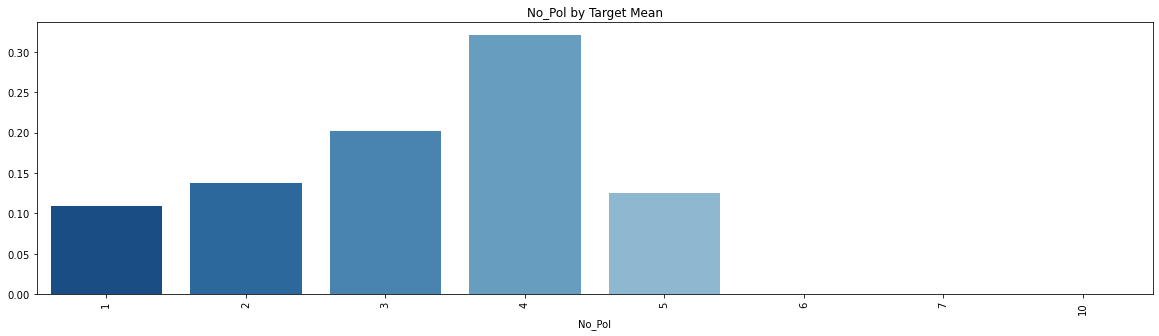

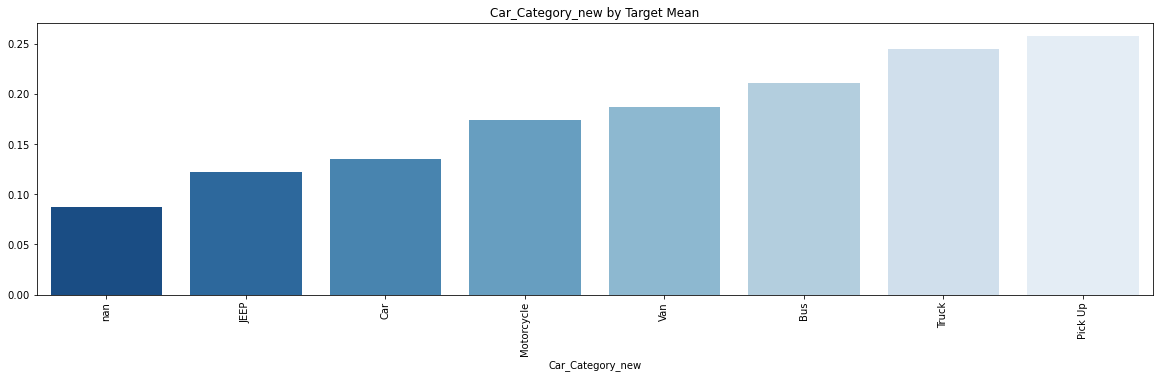

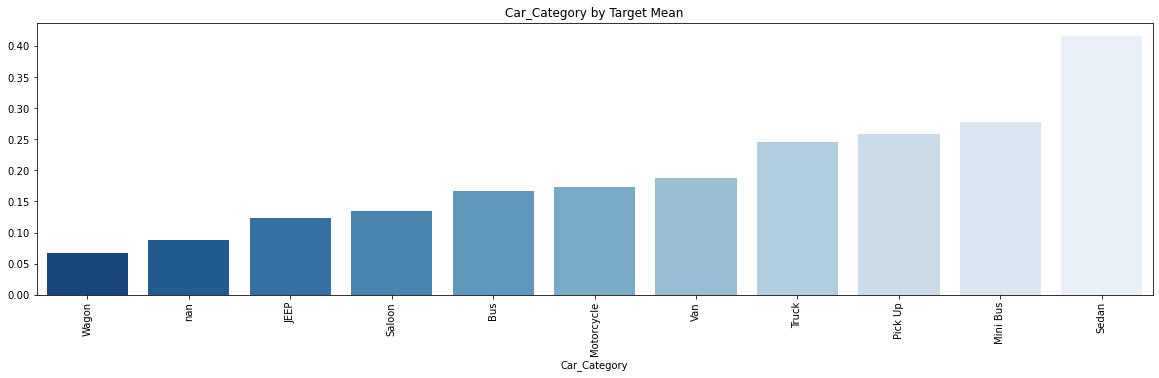

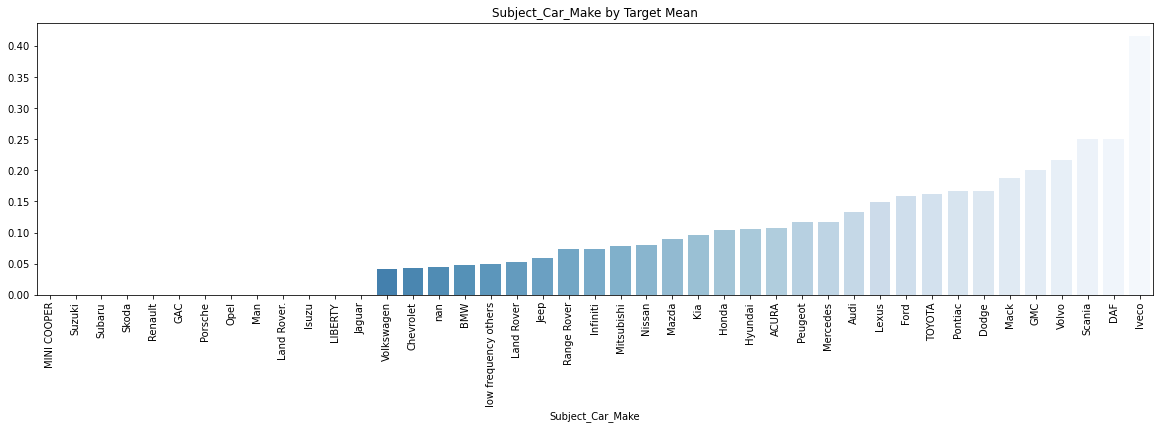

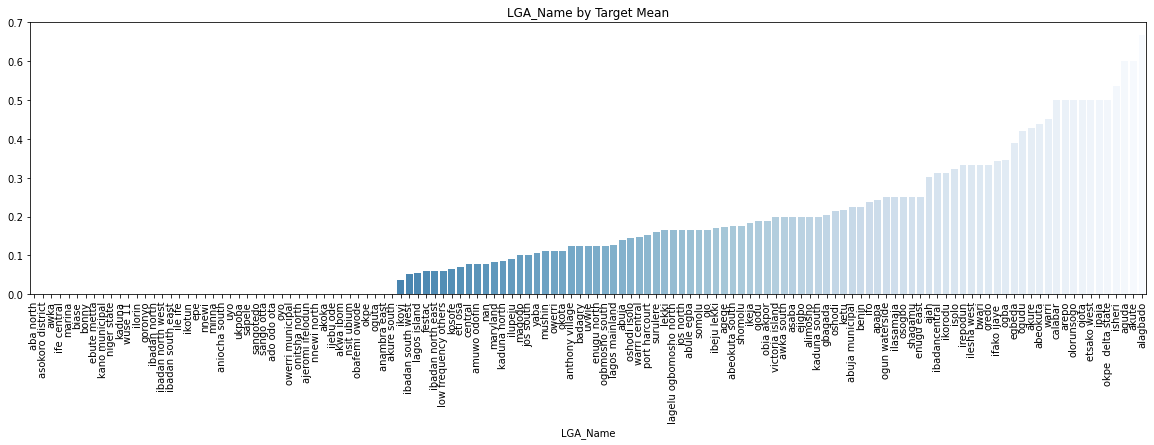

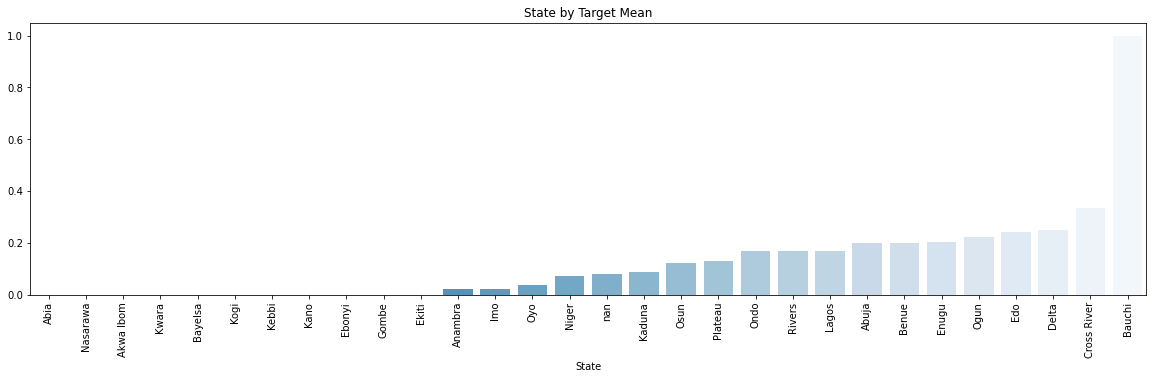

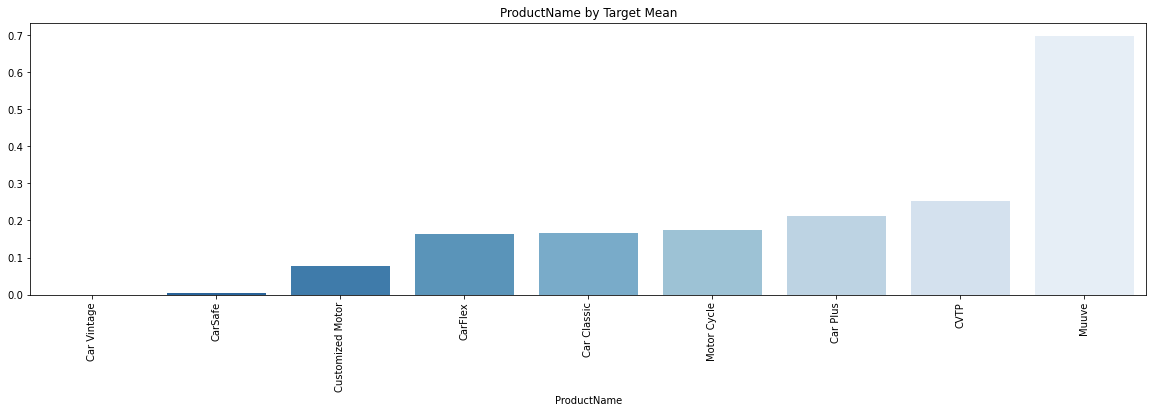

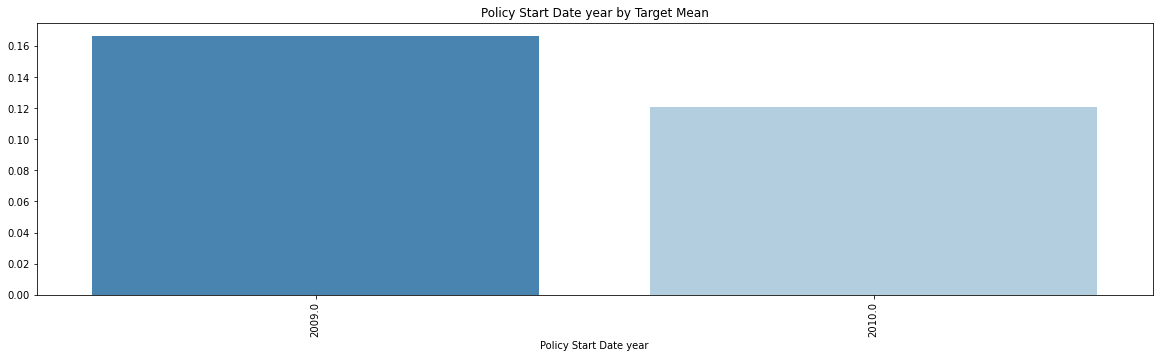

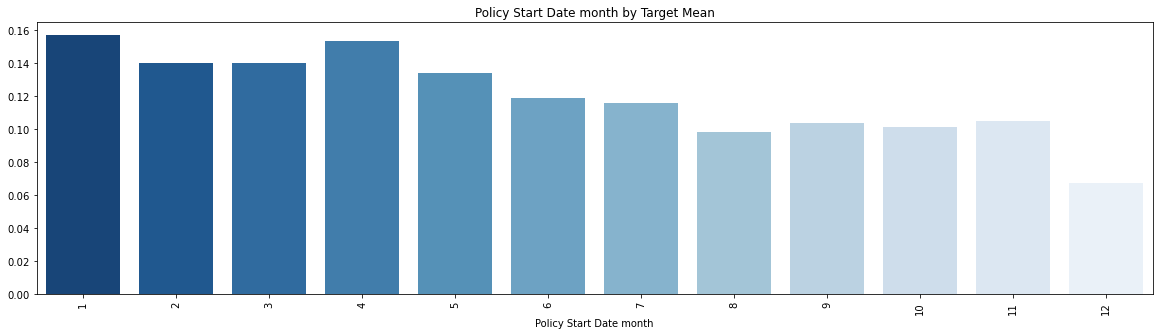

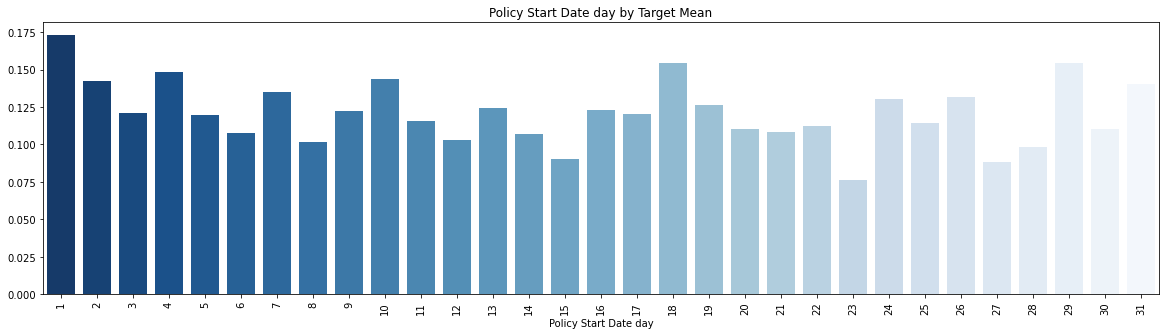

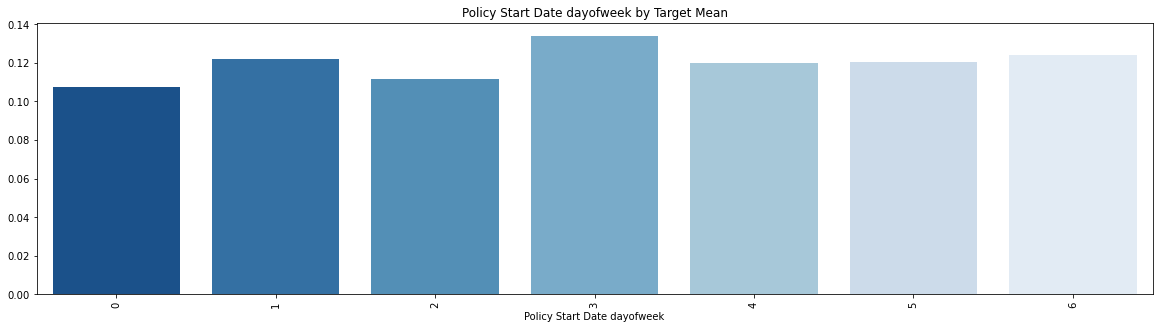

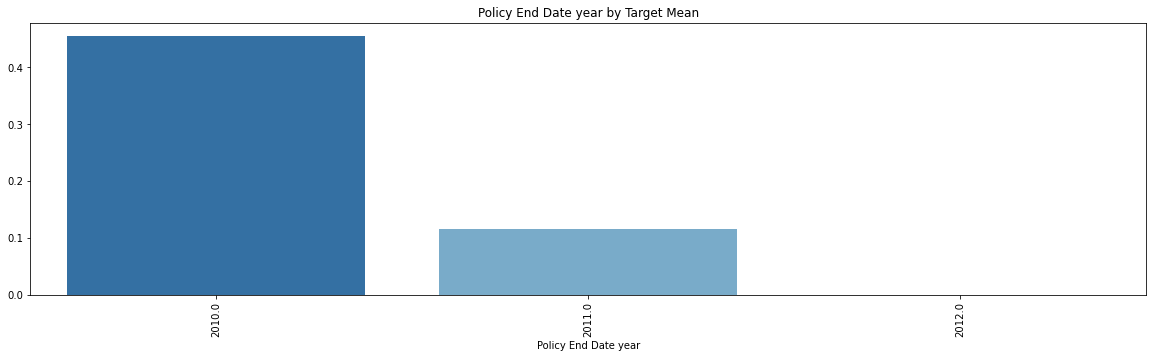

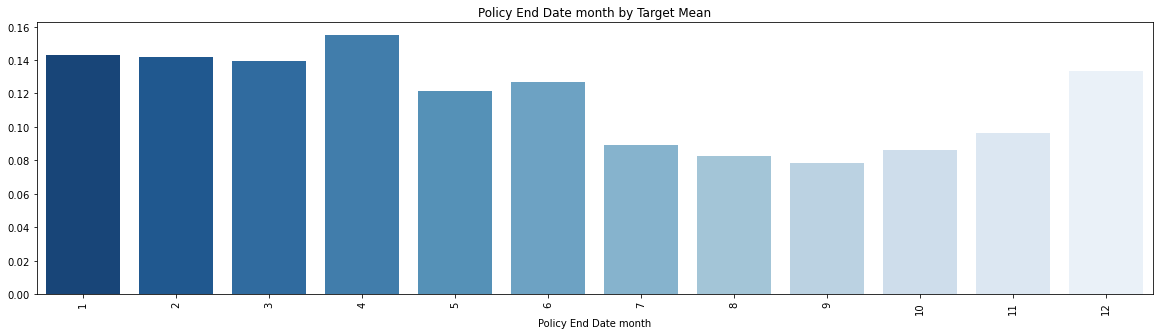

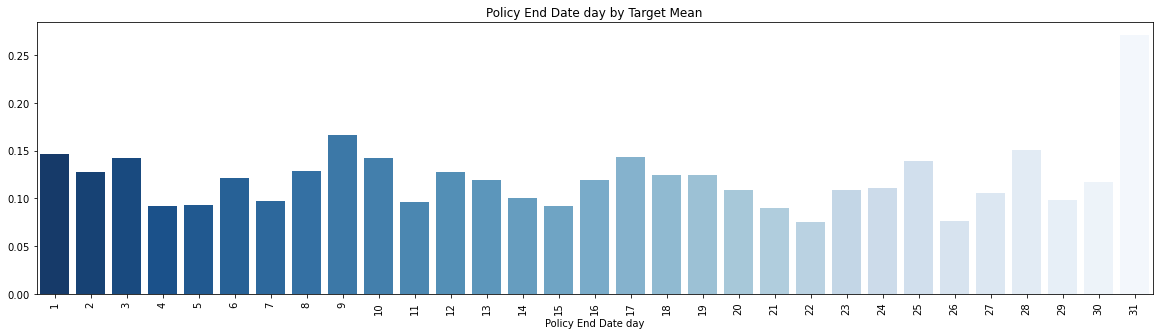

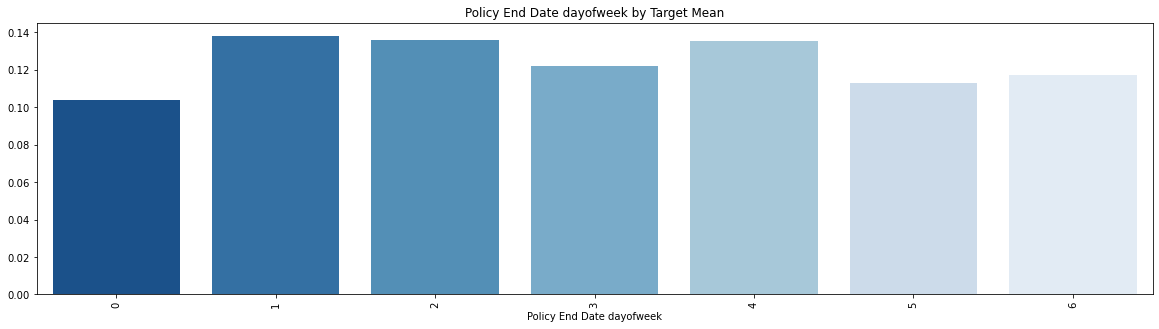

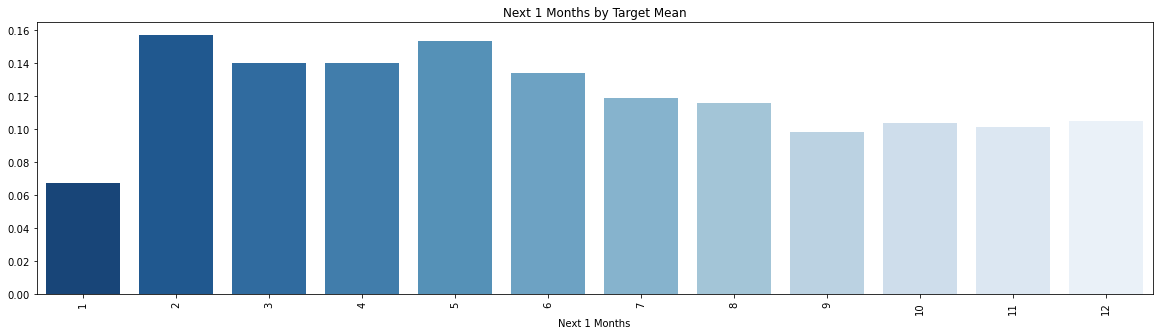

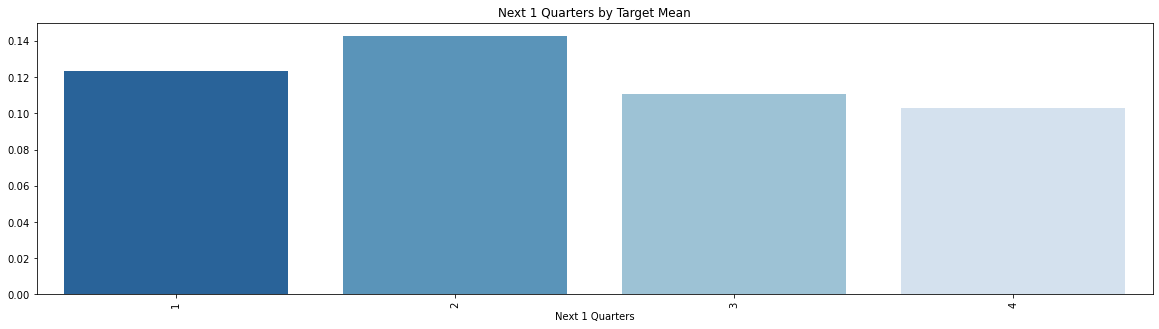

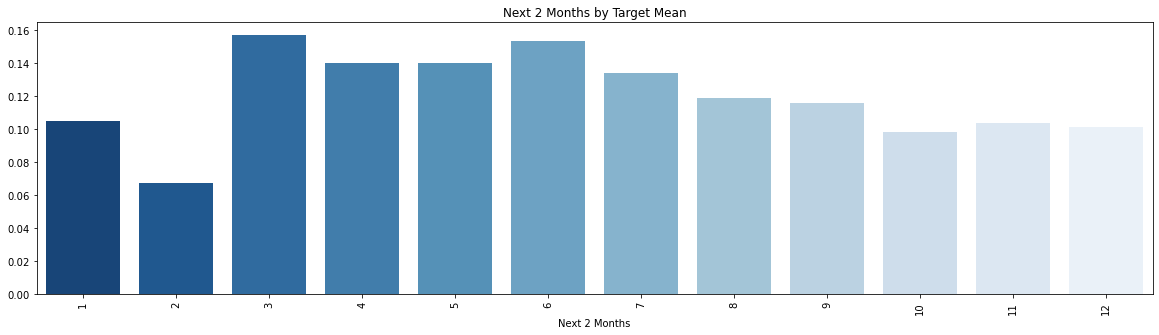

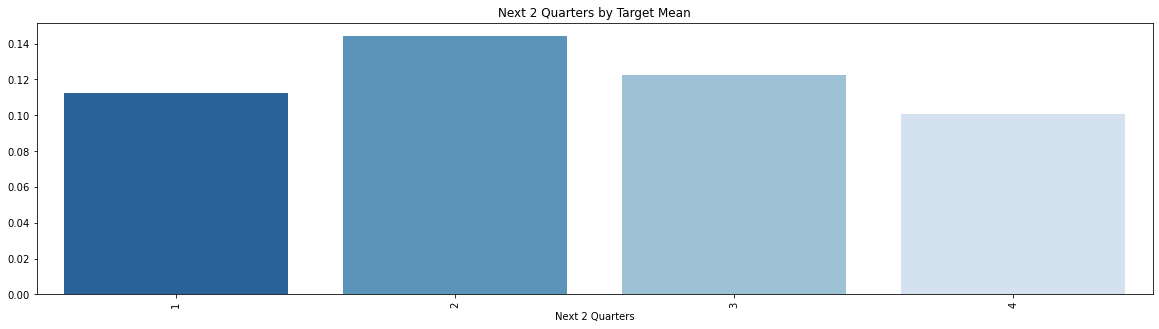

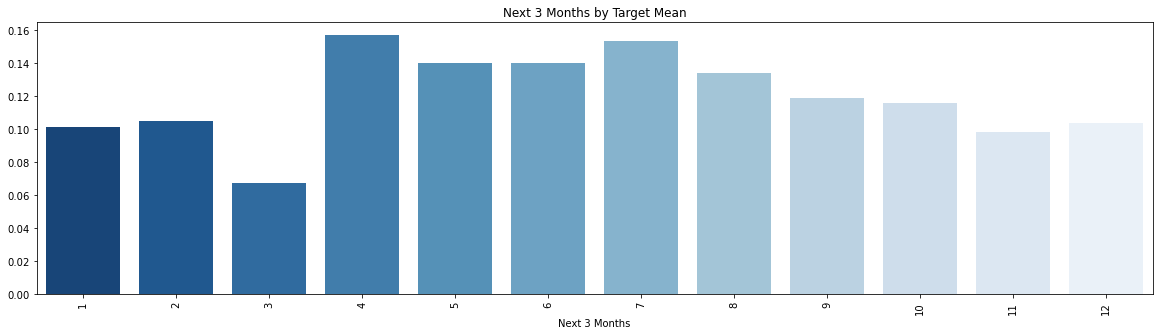

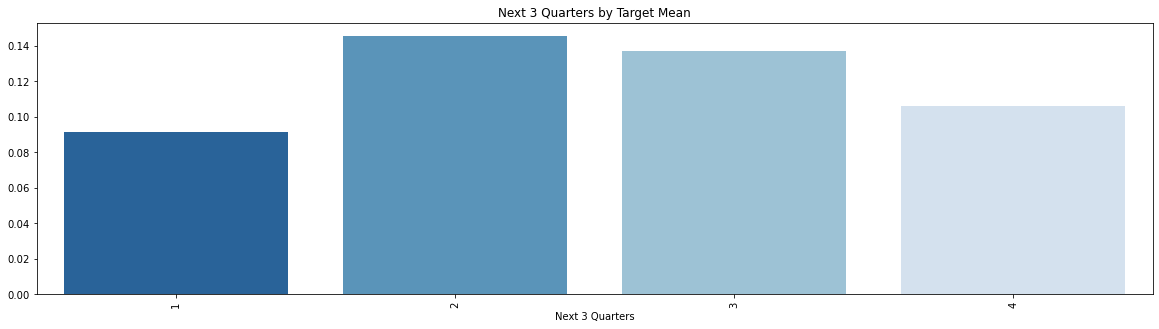

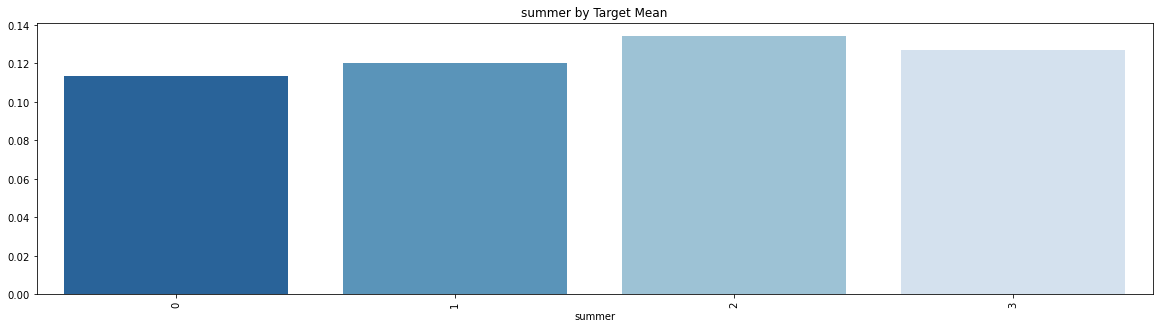

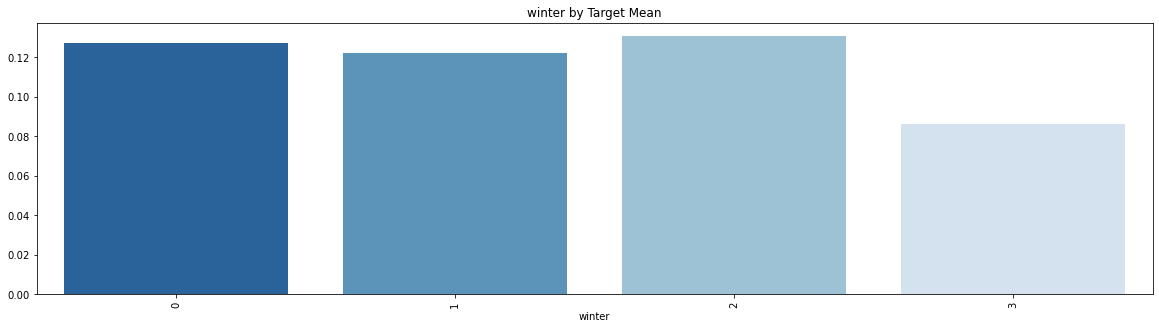

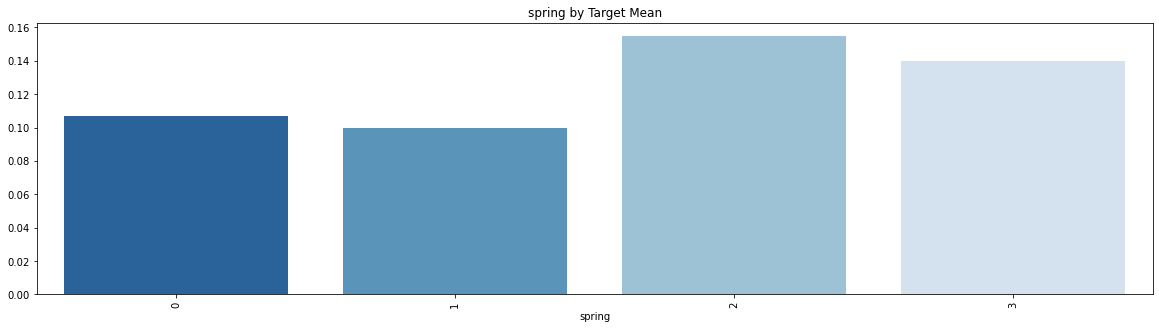

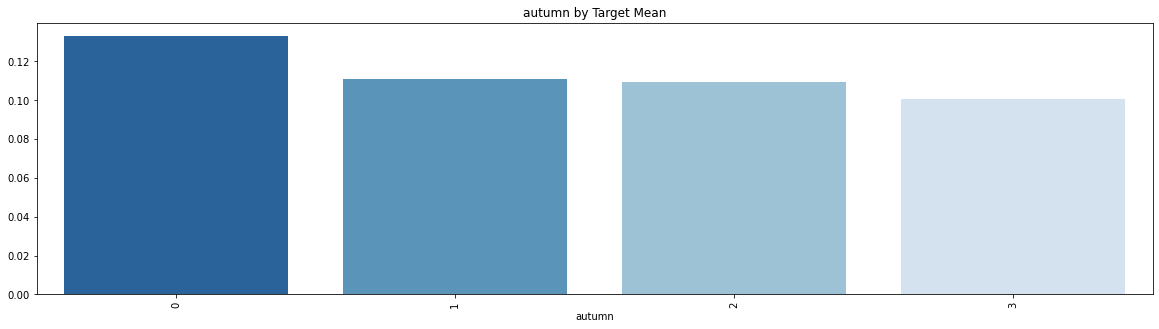

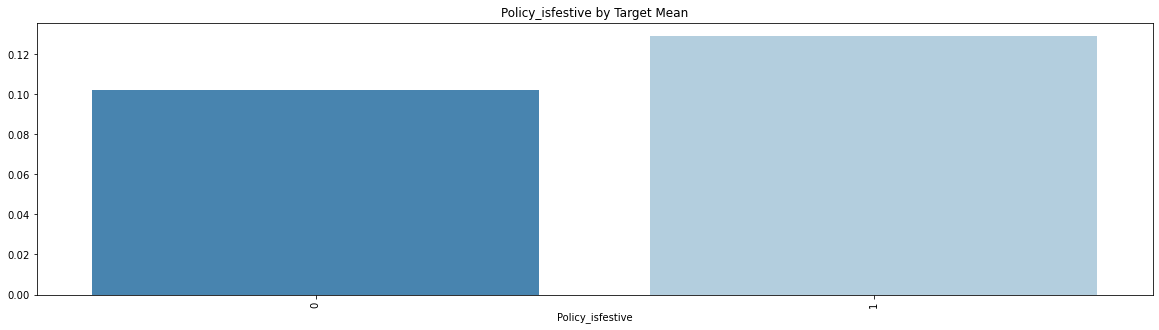

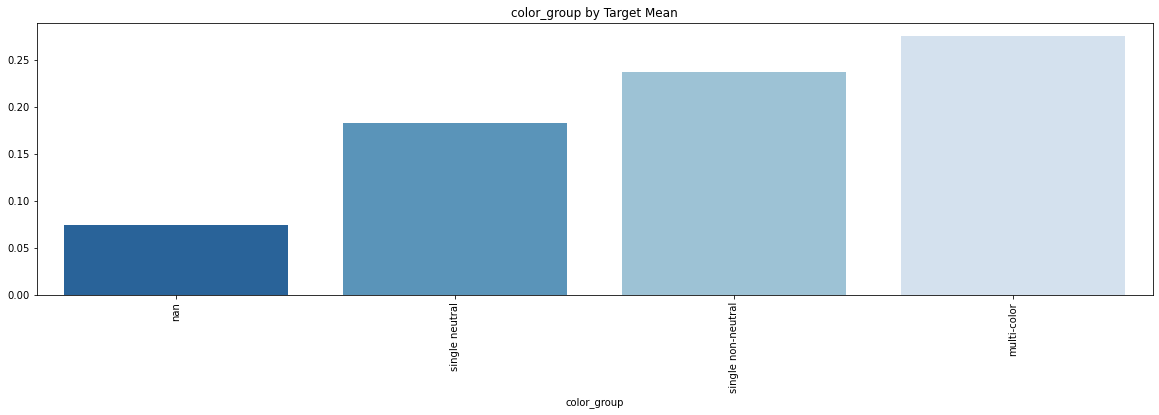

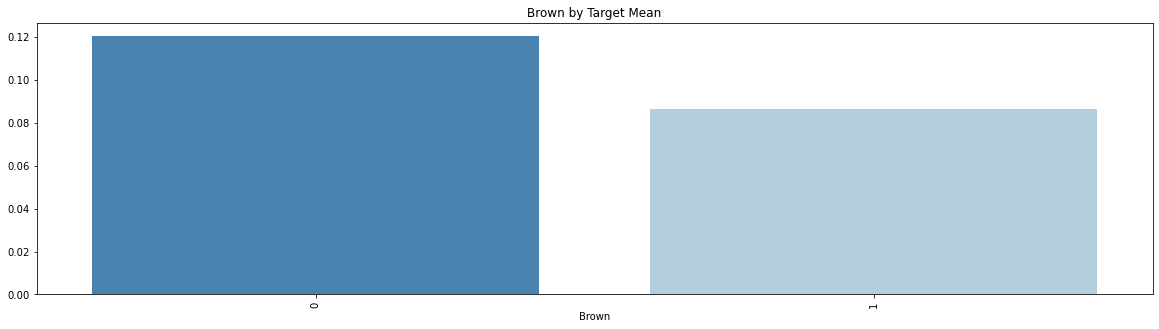

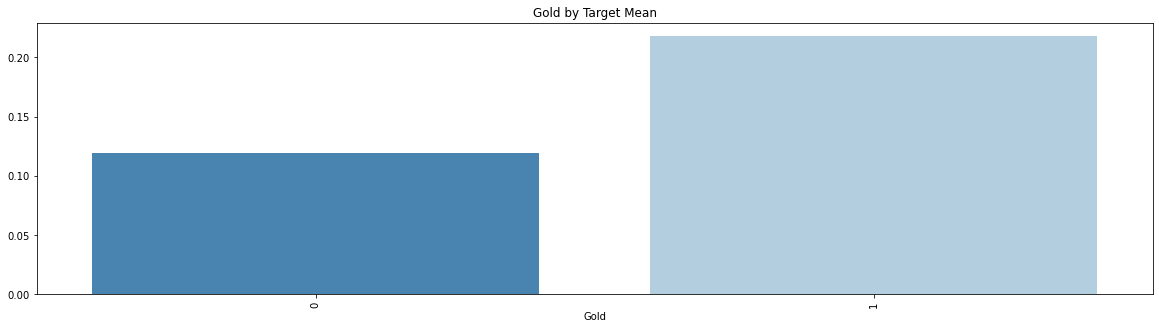

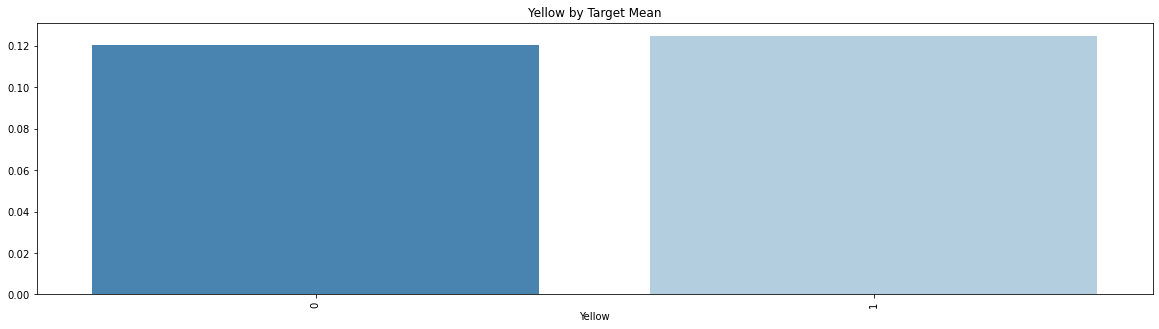

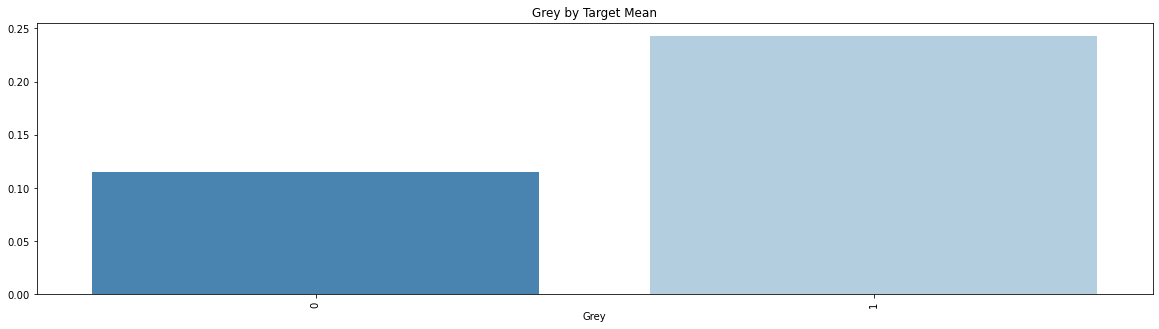

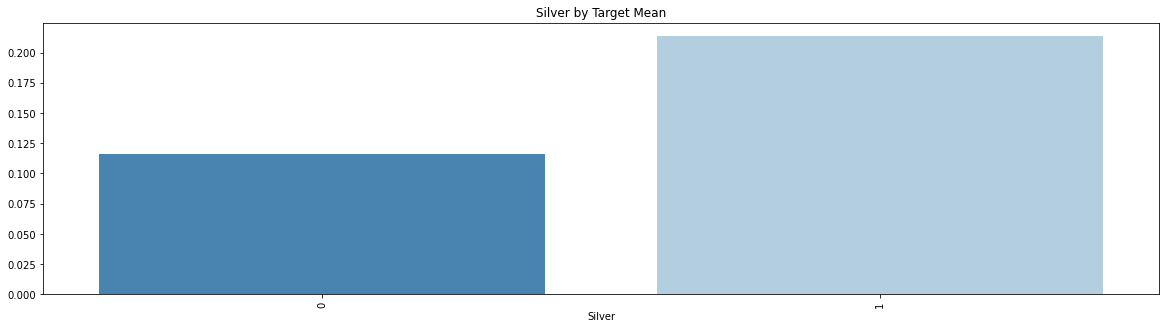

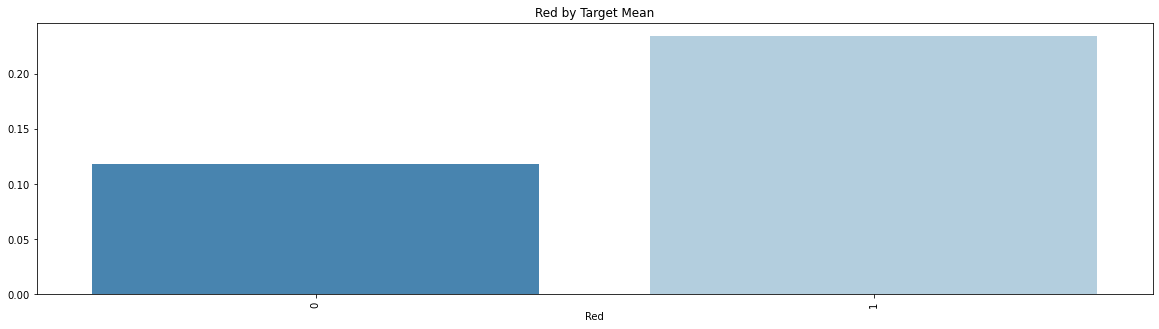

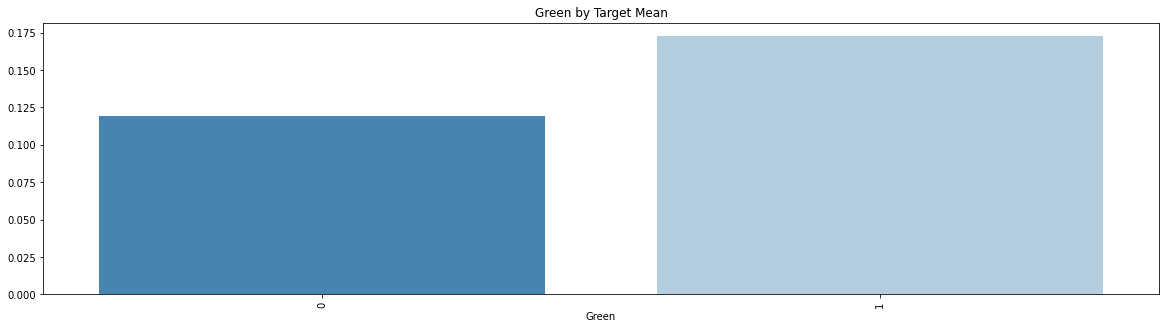

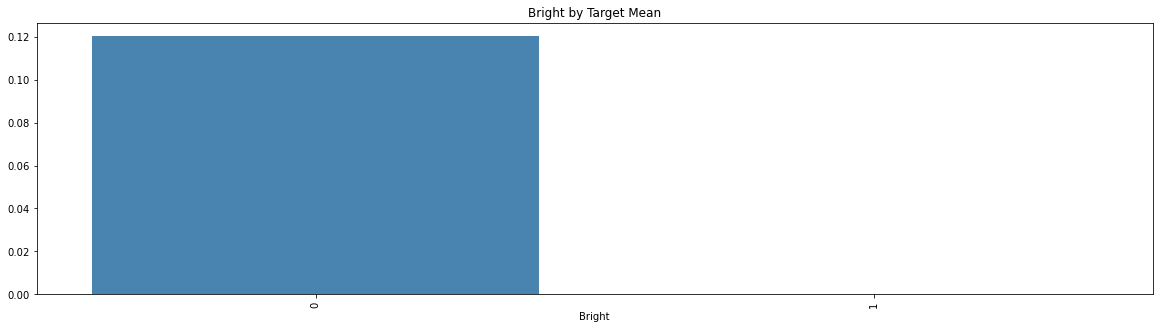

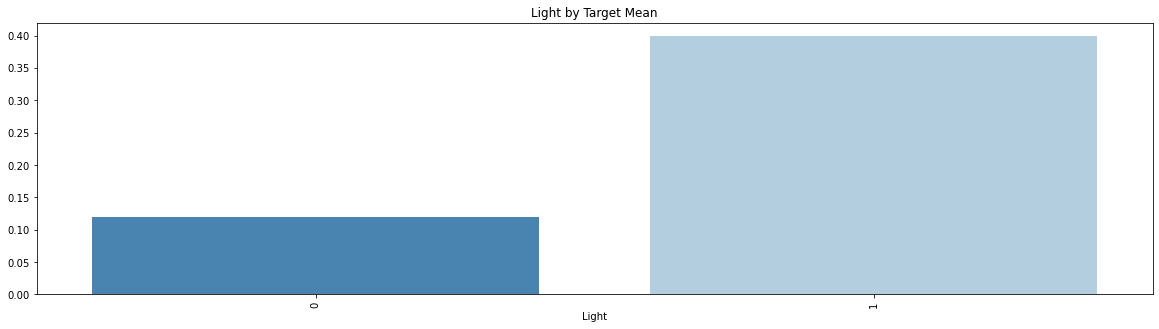

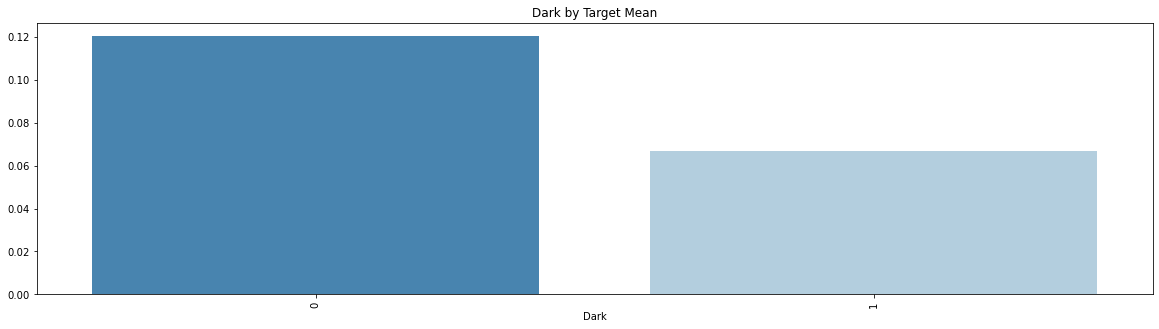

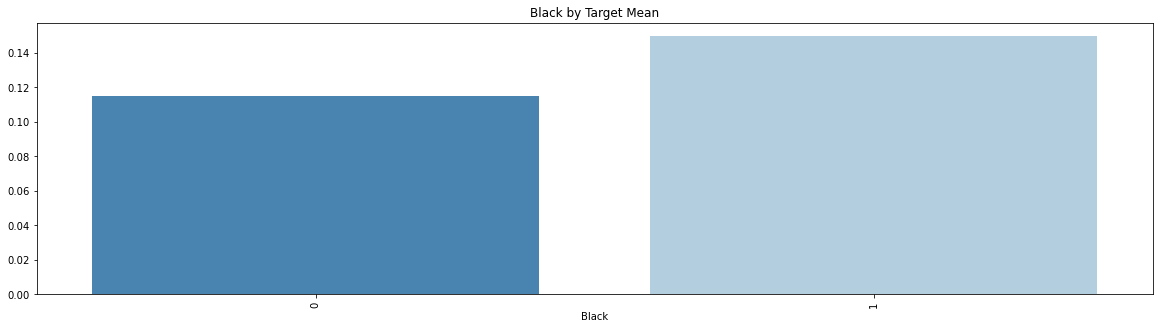

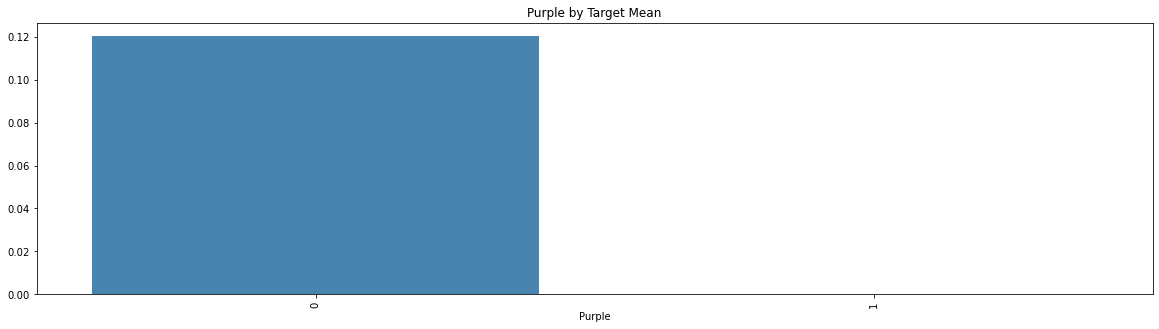

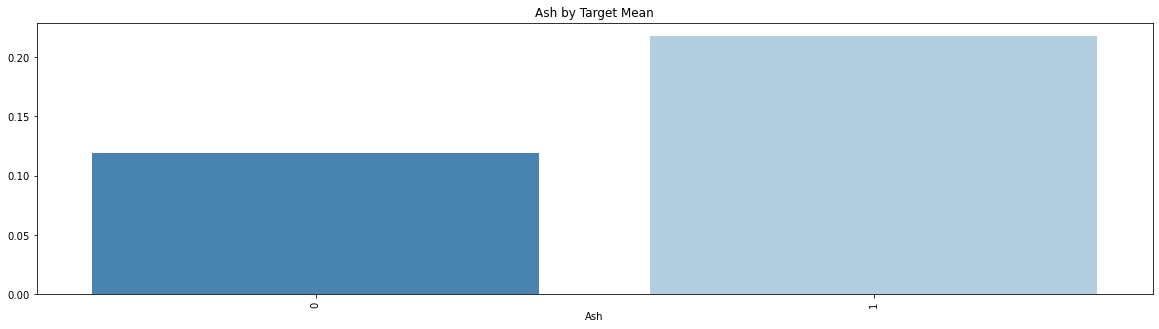

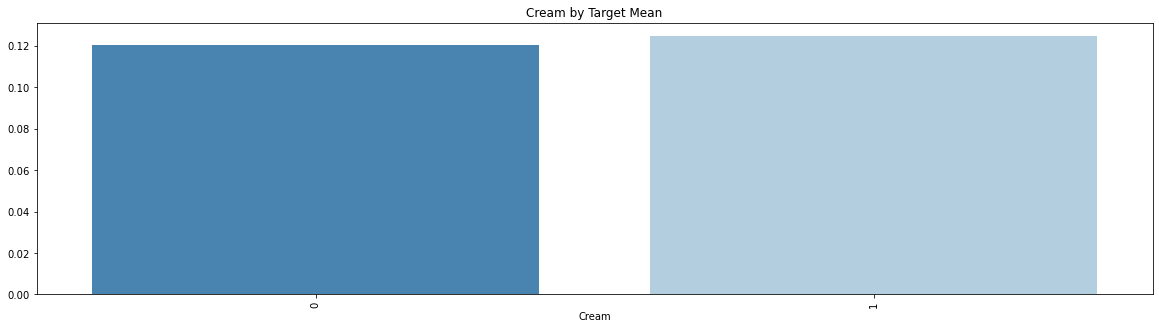

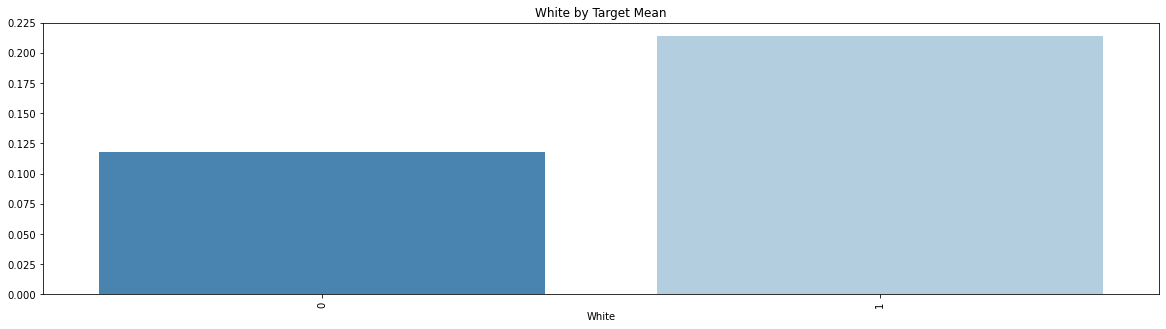

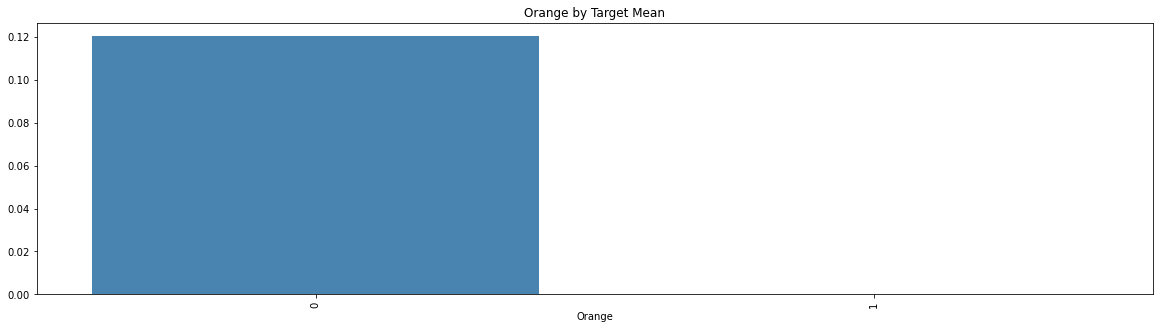

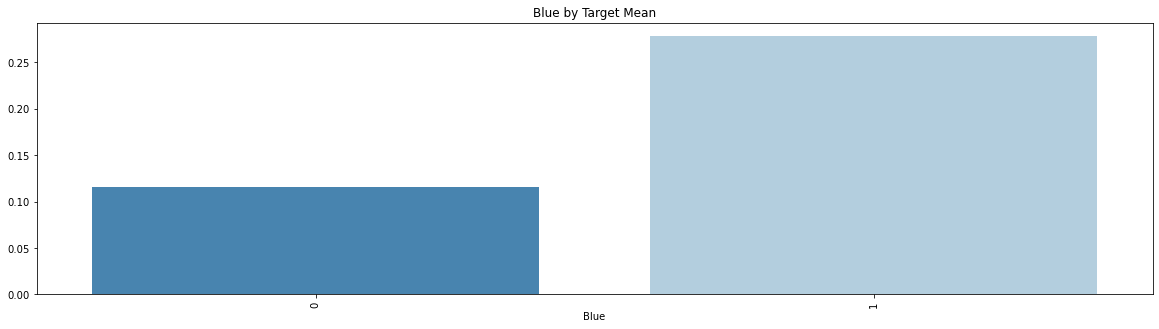

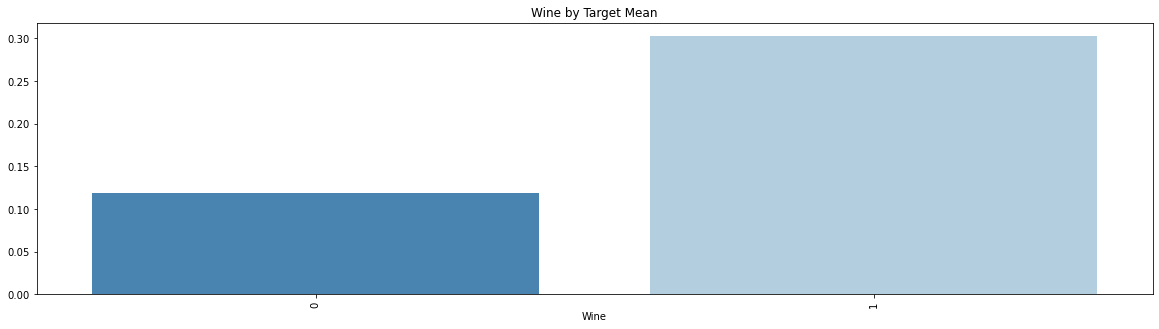

In [925]:
for col in cat_cols:
    
    plt.figure(figsize = (20, 5))
    plt.xticks(rotation = 90)
    plt.title(col + ' by Target Mean')
    
    cat = all_data.groupby(col)['target'].mean().sort_values()
    sns.barplot(cat.index, cat.values, palette = 'Blues_r')
    plt.show()

**Numerical**

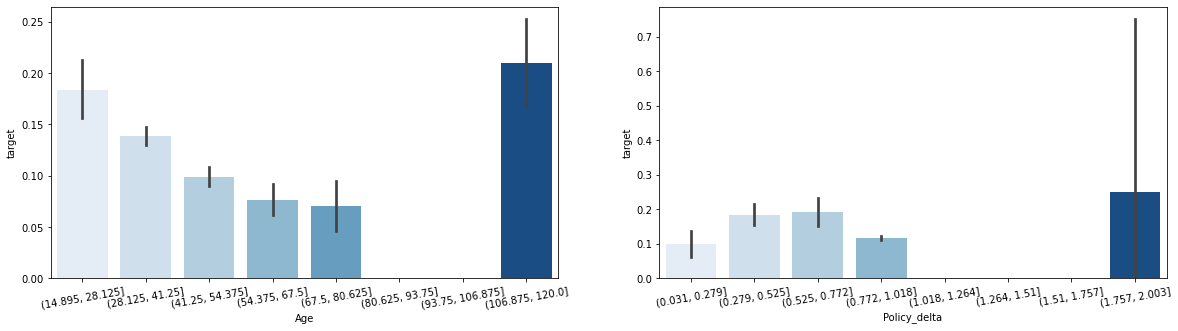

In [926]:
cont_cols = [ 'Age', 'Policy_delta']

figure, axes = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(20, 5)
# plt.subplots_adjust(wspace=0.2, hspace=0.4)

i = 0

for idx, col in enumerate(cont_cols):
    num_vis = all_data.copy()
    num_vis[col] = pd.cut(num_vis[col], 8) # Divide the value into 5 bins
    ax = axes[i]
    sns.barplot(x=col, y='target', data= num_vis, ax=ax, palette = 'Blues')
    ax.tick_params(axis='x', labelrotation=10) # Rotate x-axis label
    i += 1

## FEATURE ENGINEERING AND DATA CLEANING: Feature Combinations and data cleaning.

**Numeric Data Cleaning & Feature Engineering- Age**

In [927]:
def create_age_group(age):
    
    if age < 18:
        
        return 'minor'
    
    elif age in list(range(18, 21)):
        
        return '18-20'
    
    elif age in list(range(21, 25)):
        
        return '21-24'
    
    elif age in list(range(25, 35)):
        
        return '25-34'
    
    elif age in list(range(35, 45)):
        
        return '35-44'
    
    elif age in list(range(45, 55)):
        
        return '45-54'
    
    elif age in list(range(55, 65)):
        
        return '55-64'
    
    elif age > 64:
        
        return '65+'
    
    else:
        
        'nan'
    
    

In [928]:
def create_age_group_risk(age):
    
    if age in list(range(1, 24)):
        
        return 'high-risk youngsters'
    
    elif age in list(range(24, 30)):
        
        return 'medium-risk 24s'
    
    elif age in list(range(30, 65)):
        
        return 'low-risk mature'

    elif age > 64:
        
        return 'High-risk elderly'
    
    else:
        
        return 'nan'
    
    

In [929]:
all_data['age_group'] = all_data['Age'].apply(create_age_group)

In [930]:
all_data['age_group_risk'] = all_data['Age'].apply(create_age_group_risk)

In [931]:
all_data['Policy_delta'].isnull().sum()

11

**Creating Policy categories:**

In [932]:
def pol(pol):
    
    pol = pol * 364

    if pol  <= 95:
        
        return '3months'
    
    elif pol > 95 and pol <=185:
        
        return '6months'
    
    elif pol > 185 and pol <= 275:
        
        return '9months'
    
    elif pol > 275 and pol <= 365:
        
        return '12months'
    
    elif pol > 365:
        
        return 'a year+'
    
    else:
        return 'nan'
    
all_data['Policy_brackets'] = all_data['Policy_delta'].apply(pol)

In [933]:
all_data['Policy_brackets'].value_counts()

12months    12028
6months       604
9months       367
3months       240
a year+        31
nan            11
Name: Policy_brackets, dtype: int64

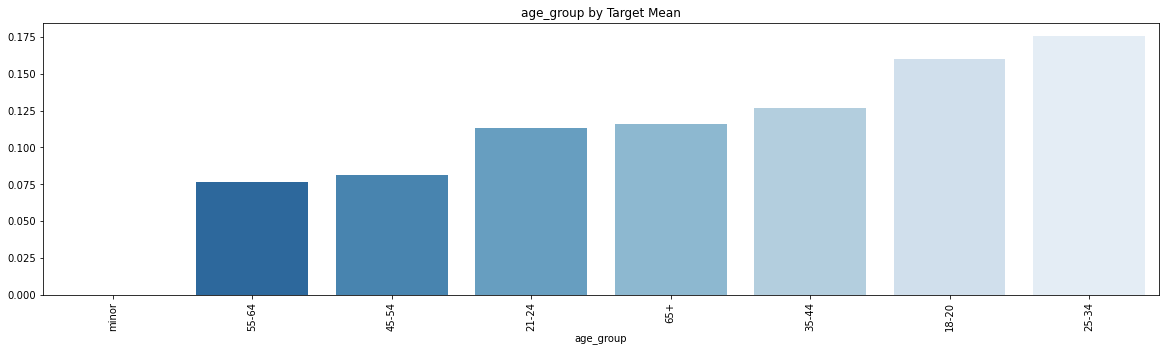

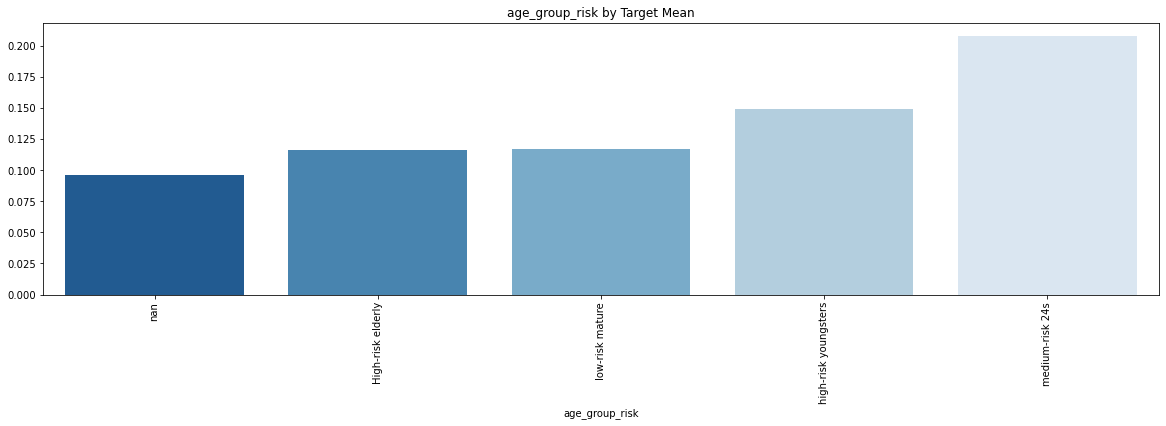

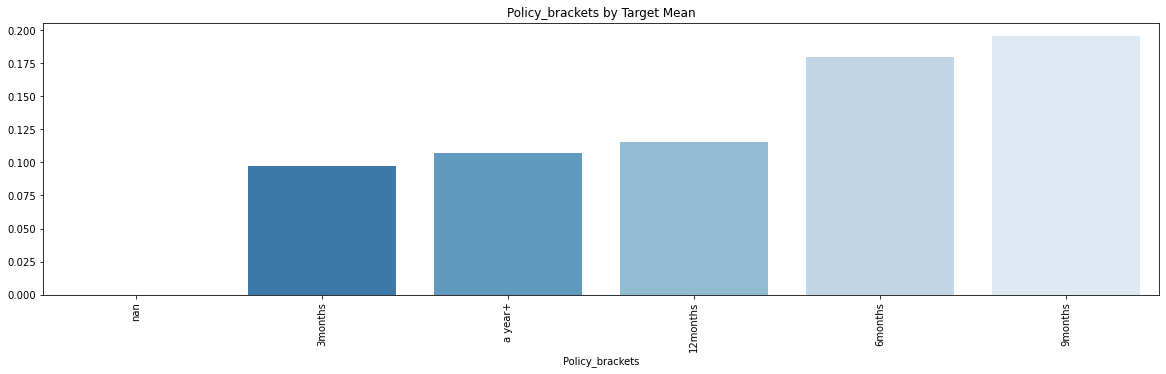

In [934]:
for col in ['age_group', 'age_group_risk', 'Policy_brackets']:
    
    plt.figure(figsize = (20, 5))
    plt.xticks(rotation = 90)
    plt.title(col + ' by Target Mean')
    
    cat = all_data.groupby(col)['target'].mean().sort_values()
    sns.barplot(cat.index, cat.values, palette = 'Blues_r')
    plt.show()

In [935]:
all_data.columns

Index(['ID', 'Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName', 'target', 'tag',
       'Policy Start Date year', 'Policy Start Date month',
       'Policy Start Date day', 'Policy Start Date dayofweek',
       'Policy End Date year', 'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'weekinmonth', 'Policy_delta',
       'Next 1 Months', 'Next 1 Quarters', 'Next 2 Months', 'Next 2 Quarters',
       'Next 3 Months', 'Next 3 Quarters', 'summer', 'winter', 'spring',
       'autumn', 'Policy_isfestive', 'color_group', 'Blue', 'Ash', 'Bright',
       'White', 'Gold', 'Wine', 'Orange', 'Dark', 'Grey', 'Black', 'Green',
       'Light', 'Brown', 'Silver', 'Red', 'Yellow', 'Cream', 'Purple',
       'Car_Category_new', 'age_group', 'age_group_risk', 'Policy_brackets'],
      dtype='object')

In [936]:
all_data['State'].value_counts()

nan            7145
Lagos          4073
Benue           693
Abuja           340
Rivers          204
Delta           138
Ogun            120
Oyo             117
Edo              78
Anambra          56
Imo              50
Kaduna           49
Enugu            47
Osun             43
Akwa Ibom        24
Plateau          24
Ondo             19
Niger            14
Kwara             9
Abia              9
Kano              7
Cross River       6
Ekiti             5
Gombe             3
Kogi              2
Ebonyi            2
Bayelsa           1
Bauchi            1
Nasarawa          1
Kebbi             1
Name: State, dtype: int64

***Categorical Feature Engineering: Create State Zone Features***

In [937]:
North_Central= 'Niger, Kogi, Benue, Plateau, Nasarawa (Nassarawa), Kwara and FCT'.split(',')
North_East = 'Bauchi, Borno, Taraba, Adamawa, Gombe and Yobe'.split(',')
North_West = 'Zamfara, Sokoto, Kaduna, Kebbi, Katsina, Kano and Jigawa'.split(',')
South_East = 'Enugu, Imo, Ebonyi, Abia and Anambra, Cross River'.split(',')
South_South = 'Bayelsa, Akwa Ibom, Edo, Rivers, Delta'.split(',')
South_West = 'Oyo, Ekiti, Osun, Ondo, Lagos and Ogun'.split(',')

In [938]:
North_Central = [i.strip() for i in North_Central]
North_East = [i.strip() for i in North_East]
North_West = [i.strip() for i in North_West]
South_East = [i.strip() for i in South_East]
South_South = [i.strip() for i in South_South]
South_West = [i.strip() for i in South_West]

In [939]:
all_data['State'].value_counts()

nan            7145
Lagos          4073
Benue           693
Abuja           340
Rivers          204
Delta           138
Ogun            120
Oyo             117
Edo              78
Anambra          56
Imo              50
Kaduna           49
Enugu            47
Osun             43
Akwa Ibom        24
Plateau          24
Ondo             19
Niger            14
Kwara             9
Abia              9
Kano              7
Cross River       6
Ekiti             5
Gombe             3
Kogi              2
Ebonyi            2
Bayelsa           1
Bauchi            1
Nasarawa          1
Kebbi             1
Name: State, dtype: int64

In [940]:
North_Central = ['Niger', 'Kogi', 'Benue', 'Plateau', 'Nasarawa', 'Kwara', 'Abuja']
North_East = ['Bauchi', 'Borno', 'Taraba', 'Adamawa', 'Gombe', 'Yobe']
North_West = ['Zamfara', 'Sokoto', 'Kaduna', 'Kebbi', 'Katsina', 'Kano', 'Jigawa']
South_East = ['Enugu', 'Imo', 'Ebonyi', 'Abia', 'Anambra', 'Cross River']
South_South = ['Bayelsa', 'Akwa Ibom', 'Edo', 'Rivers', 'Delta']
South_West = ['Oyo', 'Ekiti', 'Osun', 'Ondo', 'Lagos', 'Ogun']

In [941]:
all_data['State_zone'] = 'nan'

In [942]:
def create_geo(df, zone, zone_name):
    
    if df['State'] in zone:
        
        return zone_name
    
    else:
        
        return df['State_zone']

In [943]:
zones = [North_Central, North_East, North_West, South_East, South_South, South_West]

zones_name = ['North_Central', 'North_East', 'North_West', 'South_East', 'South_South', 'South_West']

for zone, zone_name in zip(zones, zones_name):
    
    all_data['State_zone'] = all_data.apply(create_geo, args = [zone, zone_name], axis = 1)

In [944]:
all_data['State_zone'].value_counts()

nan              7145
South_West       4377
North_Central    1083
South_South       445
South_East        170
North_West         57
North_East          4
Name: State_zone, dtype: int64

In [945]:
replace_few('State')

**Create Rainfall Features which might affect Accidents tendency : Different state regions experience rainfall at different monthly periods & peak rainfall at June**

In [946]:
all_data['is_rainfall'] = 0

In [947]:
state_zones = ['South_South', 'North_West', 'North_East', 'North_Central', 'South_West', 'South_East']

months_list = [[3, 4, 5, 6, 7, 9, 11], [6, 7, 8], [6, 7, 8], [4, 5, 6, 7, 8, 9], [3, 4, 5, 6, 7, 9, 10], \
               [3, 4, 5, 6, 7, 9, 10, 11]]

for zone, month in zip(state_zones, months_list):
    
    #Do any of the months from now to 3 months fall within rainfall periods
    
    all_data.loc[((all_data['Policy Start Date month'].isin(month)) & (all_data['State_zone'] == zone)), 'is_rainfall'] = 1
    

    all_data.loc[((all_data['Next 1 Months'].isin(month)) & (all_data['State_zone'] == zone)), 'is_rainfall'] = 1
    
    
    all_data.loc[((all_data['Next 2 Months'].isin(month)) & (all_data['State_zone'] == zone)), 'is_rainfall'] = 1
    
    
    all_data.loc[((all_data['Next 3 Months'].isin(month)) & (all_data['State_zone'] == zone)), 'is_rainfall'] = 1
    

In [948]:
all_data['is_rainfall'].value_counts()

0    7770
1    5511
Name: is_rainfall, dtype: int64

In [949]:
#Rainfall severity feature (peak in June)

all_data['is_peak'] = 0

all_data.loc[all_data['Policy Start Date month'] == 6, 'is_peak'] = 1

all_data.loc[all_data['Next 1 Months'] == 6, 'is_peak'] = 1

all_data.loc[all_data['Next 2 Months'] == 6, 'is_peak'] = 1

all_data.loc[all_data['Next 3 Months'] == 6, 'is_peak'] = 1

In [950]:
all_data['is_peak'].value_counts()

0    9000
1    4281
Name: is_peak, dtype: int64

In [951]:
all_data.columns

Index(['ID', 'Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName', 'target', 'tag',
       'Policy Start Date year', 'Policy Start Date month',
       'Policy Start Date day', 'Policy Start Date dayofweek',
       'Policy End Date year', 'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'weekinmonth', 'Policy_delta',
       'Next 1 Months', 'Next 1 Quarters', 'Next 2 Months', 'Next 2 Quarters',
       'Next 3 Months', 'Next 3 Quarters', 'summer', 'winter', 'spring',
       'autumn', 'Policy_isfestive', 'color_group', 'Blue', 'Ash', 'Bright',
       'White', 'Gold', 'Wine', 'Orange', 'Dark', 'Grey', 'Black', 'Green',
       'Light', 'Brown', 'Silver', 'Red', 'Yellow', 'Cream', 'Purple',
       'Car_Category_new', 'age_group', 'age_group_risk', 'Policy_brackets',
       'State_zone', 'is_rainfall', 'is_peak'],
      dtype='object')

In [952]:
#Create risk index

all_data['risk_index'] = all_data['is_peak'] + all_data['is_rainfall'] + all_data['Policy_isfestive']

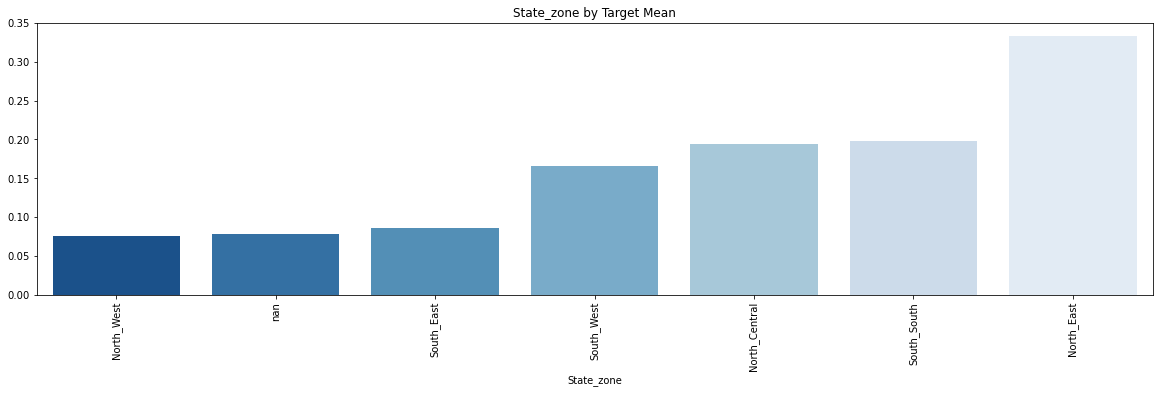

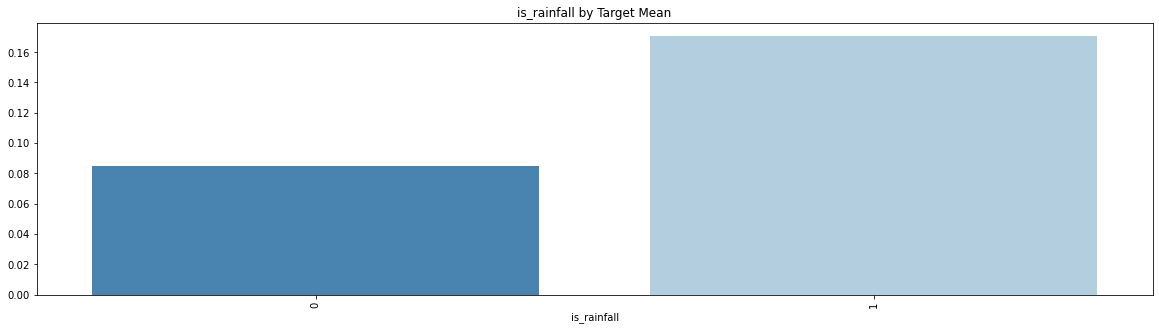

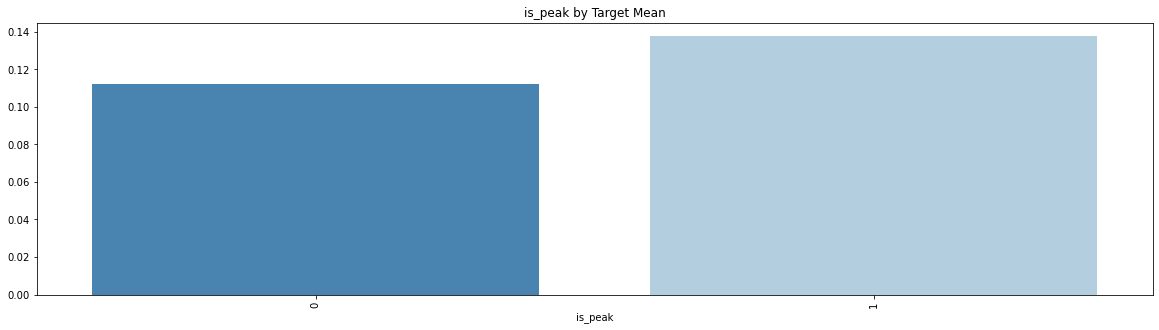

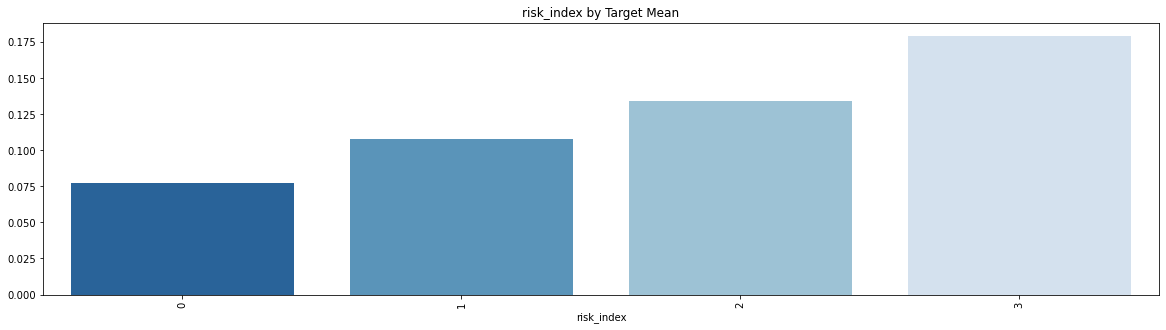

In [953]:
for col in ['State_zone', 'is_rainfall', 'is_peak', 'risk_index']:
    
    plt.figure(figsize = (20, 5))
    plt.xticks(rotation = 90)
    plt.title(col + ' by Target Mean')
    
    cat = all_data.groupby(col)['target'].mean().sort_values()
    sns.barplot(cat.index, cat.values, palette = 'Blues_r')
    plt.show()

Clear target distribution pattern with the different features. Using Target Encoding might capture the distributions better

In [954]:
len(all_data.columns)

59

In [955]:
all_data.isnull().sum(axis = 0)

ID                                0
Gender                            0
Age                             589
No_Pol                            0
Car_Category                      0
Subject_Car_Make                  0
LGA_Name                          0
State                             0
ProductName                       0
target                         1202
tag                               0
Policy Start Date year            8
Policy Start Date month           0
Policy Start Date day             0
Policy Start Date dayofweek       0
Policy End Date year              6
Policy End Date month             0
Policy End Date day               0
Policy End Date dayofweek         0
weekinmonth                       0
Policy_delta                     11
Next 1 Months                     0
Next 1 Quarters                   0
Next 2 Months                     0
Next 2 Quarters                   0
Next 3 Months                     0
Next 3 Quarters                   0
summer                      

In [956]:
all_data.describe()

,Age,No_Pol,target,Policy Start Date year,Policy Start Date month,Policy Start Date day,Policy Start Date dayofweek,Policy End Date year,Policy End Date month,Policy End Date day,...,Light,Brown,Silver,Red,Yellow,Cream,Purple,is_rainfall,is_peak,risk_index
count,12692.000000,13281.000000,12079.000000,13273.000000,13281.000000,13281.000000,13281.000000,13275.000000,13281.000000,13281.000000,...,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.000000,13281.00000,13281.000000
mean,45.446265,1.302763,0.120457,2009.999548,6.382275,16.154506,3.445524,2010.986817,5.871169,15.998494,...,0.000376,0.004894,0.045855,0.021083,0.000602,0.000753,0.000301,0.414954,0.32234,1.413523
std,18.008903,0.723195,0.325509,0.021257,3.502905,8.874429,2.120057,0.115374,3.501813,8.963396,...,0.019400,0.069790,0.209178,0.143666,0.024537,0.027431,0.017353,0.492733,0.46739,1.001239
min,15.000000,1.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,2010.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,35.000000,1.000000,0.000000,2010.000000,3.000000,8.000000,2.000000,2011.000000,3.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,41.000000,1.000000,0.000000,2010.000000,6.000000,16.000000,4.000000,2011.000000,5.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,50.000000,1.000000,0.000000,2010.000000,9.000000,24.000000,5.000000,2011.000000,9.000000,24.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,2.000000
max,120.000000,10.000000,1.000000,2010.000000,12.000000,31.000000,6.000000,2012.000000,12.000000,31.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,3.000000


In [957]:
all_data.columns

Index(['ID', 'Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName', 'target', 'tag',
       'Policy Start Date year', 'Policy Start Date month',
       'Policy Start Date day', 'Policy Start Date dayofweek',
       'Policy End Date year', 'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'weekinmonth', 'Policy_delta',
       'Next 1 Months', 'Next 1 Quarters', 'Next 2 Months', 'Next 2 Quarters',
       'Next 3 Months', 'Next 3 Quarters', 'summer', 'winter', 'spring',
       'autumn', 'Policy_isfestive', 'color_group', 'Blue', 'Ash', 'Bright',
       'White', 'Gold', 'Wine', 'Orange', 'Dark', 'Grey', 'Black', 'Green',
       'Light', 'Brown', 'Silver', 'Red', 'Yellow', 'Cream', 'Purple',
       'Car_Category_new', 'age_group', 'age_group_risk', 'Policy_brackets',
       'State_zone', 'is_rainfall', 'is_peak', 'risk_index'],
      dtype='object')

In [958]:
#Convert back to msising values

all_data = all_data.replace('nan', np.nan)

In [959]:
all_data.isnull().sum()

ID                                0
Gender                         1246
Age                             589
No_Pol                            0
Car_Category                   4085
Subject_Car_Make               2785
LGA_Name                       7145
State                          7145
ProductName                       0
target                         1202
tag                               0
Policy Start Date year            8
Policy Start Date month           0
Policy Start Date day             0
Policy Start Date dayofweek       0
Policy End Date year              6
Policy End Date month             0
Policy End Date day               0
Policy End Date dayofweek         0
weekinmonth                       0
Policy_delta                     11
Next 1 Months                     0
Next 1 Quarters                   0
Next 2 Months                     0
Next 2 Quarters                   0
Next 3 Months                     0
Next 3 Quarters                   0
summer                      

**Combination Features**

In [960]:
all_data['Gender_age_risk'] = all_data['Gender'] + '- ' + all_data['age_group_risk']

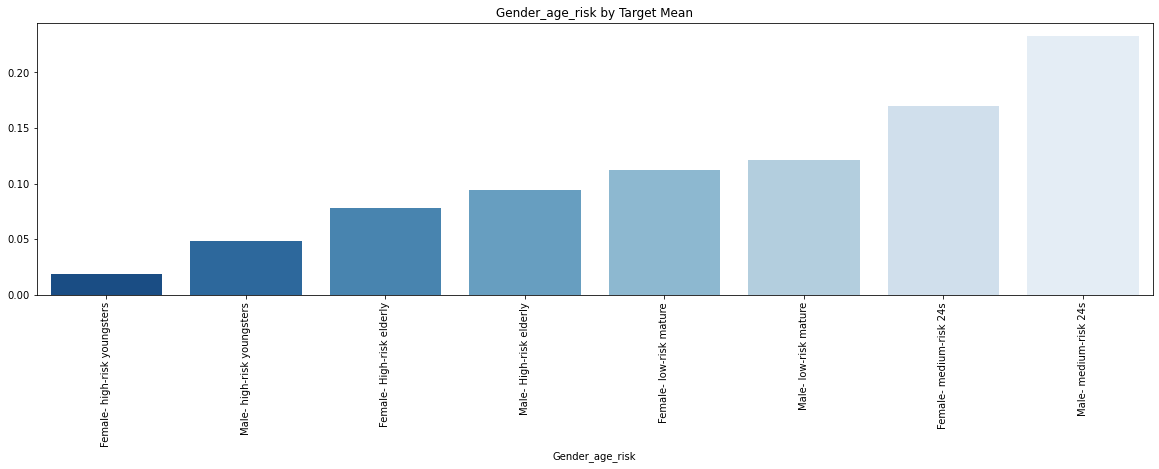

In [961]:
for col in ['Gender_age_risk']:
    
    plt.figure(figsize = (20, 5))
    plt.xticks(rotation = 90)
    plt.title(col + ' by Target Mean')
    
    cat = all_data.groupby(col)['target'].mean().sort_values()
    sns.barplot(cat.index, cat.values, palette = 'Blues_r')
    plt.show()

In [962]:
all_data.columns

Index(['ID', 'Gender', 'Age', 'No_Pol', 'Car_Category', 'Subject_Car_Make',
       'LGA_Name', 'State', 'ProductName', 'target', 'tag',
       'Policy Start Date year', 'Policy Start Date month',
       'Policy Start Date day', 'Policy Start Date dayofweek',
       'Policy End Date year', 'Policy End Date month', 'Policy End Date day',
       'Policy End Date dayofweek', 'weekinmonth', 'Policy_delta',
       'Next 1 Months', 'Next 1 Quarters', 'Next 2 Months', 'Next 2 Quarters',
       'Next 3 Months', 'Next 3 Quarters', 'summer', 'winter', 'spring',
       'autumn', 'Policy_isfestive', 'color_group', 'Blue', 'Ash', 'Bright',
       'White', 'Gold', 'Wine', 'Orange', 'Dark', 'Grey', 'Black', 'Green',
       'Light', 'Brown', 'Silver', 'Red', 'Yellow', 'Cream', 'Purple',
       'Car_Category_new', 'age_group', 'age_group_risk', 'Policy_brackets',
       'State_zone', 'is_rainfall', 'is_peak', 'risk_index',
       'Gender_age_risk'],
      dtype='object')

In [963]:
all_data['No Pol/Age'] = all_data['No_Pol'] / all_data['Age']

In [964]:
#FINAL DATA AFTER PREPARATION

all_data.to_csv('all_data_processed_finaleng_2.csv')